In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import itertools
import torch
import random
import os
import wandb
import scipy.stats as stats

from visuals import CLRS_MILA
from RLutils.model import ACModelSR
from RLutils.analysis import EnvironmentFeaturesAnalysis
from RLutils.other import device
from RLutils.format import get_obss_preprocessor
from prnn.utils.general import saveFig
from prnn.utils.predictiveNet import PredictiveNet
from prnn.utils.agent import RandomActionAgent
from prnn.analysis.representationalGeometryAnalysis import representationalGeometryAnalysis

api = wandb.Api()

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-BlockedUnlockPickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N1-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N2-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN

In [3]:
savefolder_5 = 'LabNotebook/20242907_hyperparam_seq5/'

aF_seq_5 = pd.read_pickle(savefolder_5 + 'aF_seq_5.pkl')

In [4]:
savefolder_1 = 'LabNotebook/20242907_hyperparam_seq1/'

aF_seq_1 = pd.read_pickle(savefolder_1 + 'aF_seq_1.pkl')

In [40]:
# nettypes = ['thRNN_1win']
nettypes = ['thRNN_5win']
# kvalues = ['2']
# hpidx = ['0','2','3','4','5','7','8','9','10',
        #  '11','12','13','14','15','16','17','18','19']
hpidx = ['0','1','2','3','4','5','6','7','8','9','10',
         '11','12','13','14','15','16','17','18','19']
# seeds = ['0','1','2','3','4','5','6','7','8','9']
seeds = ['1000','2000','3000','4000','5000']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]

netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
netk = [int(name[2]) for name in netprops]

analysisFrame = pd.DataFrame(data={'filename':netnames, 'type':nettype})

In [41]:
netfolder = '/hyperparm_panel_lava_k5_midsparse/'
# netfolder = '/hyperparm_panel_lava_k1_midsparse/'
def loadNet(row):
    try:
        net = PredictiveNet.loadNet(netfolder+row['filename'],suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        

analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)

In [42]:
#analysisFrame['net'][0].trainArgs
def getTrainParms(row):
    predictiveNet = row['net']
    lr = predictiveNet.trainArgs.lr
    seed = predictiveNet.trainArgs.seed
    weight_decay = predictiveNet.trainArgs.weight_decay
    bptttrunc = predictiveNet.trainArgs.bptttrunc
    seqdur = predictiveNet.trainArgs.seqdur
    dropp = predictiveNet.trainArgs.dropout
    ntimescale = predictiveNet.trainArgs.ntimescale
    nneurons = predictiveNet.trainArgs.hiddensize
    noisestd = predictiveNet.trainArgs.noisestd
    # sparsity = predictiveNet.trainArgs.sparsity
    epochs = predictiveNet.numTrainingEpochs
    # bias_lr = predictiveNet.trainArgs.bias_lr
    
    # return lr,bptttrunc,seqdur,seed,dropp,ntimescale,weight_decay,nneurons,noisestd,sparsity,epochs,bias_lr
    return lr,bptttrunc,seqdur,seed,dropp,ntimescale,weight_decay,nneurons,noisestd,epochs
# analysisFrame[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay','nneurons','noisestd','sparsity','epochs','bias_lr']] = analysisFrame.apply(getTrainParms, axis = 1, result_type="expand")
analysisFrame[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay','nneurons','noisestd','epochs']] = analysisFrame.apply(getTrainParms, axis = 1, result_type="expand")

In [43]:
path = '/network/scratch/a/aleksei.efremov/RLstorage/Hparams_midsparse_comparison/'
start = 'Seq_5_'

# path = '/network/scratch/a/aleksei.efremov/RLstorage/Hparams_midsparse_comparison_k1/'
# start = 'Seq_1_'

def find_latest(list):
    latest = ''
    for name in list:
        if name>latest:
            latest = name
    return latest

def loadACnets(row, path, start):
    seed = int(row['filename'][-4:])
    n = row['filename'][11:13]
    n = int(''.join(i for i in n if i.isdigit()))
    name = start+str(seed+n)+'_'
    finds = []
    for x in os.listdir(path):
        if x.startswith(name):
            finds.append(x)
    latest = find_latest(finds)
    try:
        stat = torch.load(path+latest+'/status.pt')
        model = ACModelSR(row['net'].env_shell.observation_space,
                    row['net'].env_shell.action_space,
                    SR_size = int(row['nneurons']),
                    with_CV = False)
        model.load_state_dict(stat['model_state'])
    except:
        print(f"couldn't load {row['filename']}")
        model = None
    return model

def loadACnetsVis(row, path, start):
    obs_space, _ = get_obss_preprocessor(row['net'].env_shell.observation_space)
    seed = int(row['filename'][-4:])
    n = row['filename'][11:13]
    n = int(''.join(i for i in n if i.isdigit()))
    name = start+str(seed+n)+'+Visual_'
    finds = []
    for x in os.listdir(path):
        if x.startswith(name):
            finds.append(x)
    latest = find_latest(finds)
    try:
        stat = torch.load(path+latest+'/status.pt')
        model = ACModelSR(obs_space,
                    row['net'].env_shell.action_space,
                    SR_size = int(row['nneurons']))
        model.load_state_dict(stat['model_state'])
    except:
        print(f"Visual: couldn't load {row['filename']}")
        model = None
    return model

def loadACnetsInt(row, path, start):
    seed = int(row['filename'][-4:])
    n = row['filename'][11:13]
    n = int(''.join(i for i in n if i.isdigit()))
    name = start+str(seed+n)+'+Intrinsic_'
    finds = []
    for x in os.listdir(path):
        if x.startswith(name):
            finds.append(x)
    latest = find_latest(finds)
    try:
        stat = torch.load(path+latest+'/status.pt')
        model = ACModelSR(row['net'].env_shell.observation_space,
                    row['net'].env_shell.action_space,
                    SR_size = int(row['nneurons']),
                    with_CV = False)
        model.load_state_dict(stat['model_state'])
    except:
        print(f"Intrinsic: couldn't load {row['filename']}")
        model = None
    return model

analysisFrame['ACnet'] = analysisFrame.apply(loadACnets, axis = 1, result_type="expand", path = path, start = start)
analysisFrame['ACnet_vis'] = analysisFrame.apply(loadACnetsVis, axis = 1, result_type="expand", path = path, start = start)
analysisFrame['ACnet_int'] = analysisFrame.apply(loadACnetsInt, axis = 1, result_type="expand", path = path, start = start)

In [10]:
from scipy.spatial.distance import cosine

def getTargetDists(row):
    net = row['net']
    reps = [net.TrainingSaver['place_fields'].iloc[-1][n] for n in range(net.trainArgs.hiddensize)]
    rep = np.array(reps)

    dists = np.zeros([17,13])
    for x in range(17):
        for y in range(13):
            dists[x,y] = cosine(rep[:,x,y],rep[:,6,6])
    return dists


# analysisFrame['targetDists'] = analysisFrame.apply(getTargetDists, axis = 1)
# for idx,row in analysisFrame.iterrows():
#     analysisFrame['targetDists'][idx] = getTargetDists(row)

In [7]:
len(analysisFrame[analysisFrame['epochs']==40])

100

In [67]:
analysisFrame[analysisFrame['epochs']!=80]

filename        type  \
0    thRNN_5win-0-s1000  thRNN_5win   
1    thRNN_5win-0-s2000  thRNN_5win   
2    thRNN_5win-0-s3000  thRNN_5win   
3    thRNN_5win-0-s4000  thRNN_5win   
4    thRNN_5win-0-s5000  thRNN_5win   
..                  ...         ...   
95  thRNN_5win-19-s1000  thRNN_5win   
96  thRNN_5win-19-s2000  thRNN_5win   
97  thRNN_5win-19-s3000  thRNN_5win   
98  thRNN_5win-19-s4000  thRNN_5win   
99  thRNN_5win-19-s5000  thRNN_5win   

                                                  net        lr    bptt  \
0   <prnn.utils.predictiveNet.PredictiveNet object...  0.012405     9.0   
1   <prnn.utils.predictiveNet.PredictiveNet object...  0.002624   470.0   
2   <prnn.utils.predictiveNet.PredictiveNet object...  0.006446    84.0   
3   <prnn.utils.predictiveNet.PredictiveNet object...  0.002182   420.0   
4   <prnn.utils.predictiveNet.PredictiveNet object...  0.000947   206.0   
..                                                ...       ...     ...   
95  <prnn.utils.predictiveNet.PredictiveNet object...  0.003170    33.0   
96  <prnn.utils.predictiveNet.PredictiveNet object...  0.000550    25.0   
97  <prnn.utils.predictiveNet.PredictiveNet object...  0.000578   158.0   
98  <prnn.utils.predictiveNet.PredictiveNet object...  0.000449    77.0   
99  <prnn.utils.predictiveNet.PredictiveNet object...  0.002540  1006.0   

    seqdur    seed     dropp  ntimescale  weight_decay  ...    meanSI  \
0    505.0  1000.0  0.153335    1.309331      0.001623  ...  0.769798   
1    121.0  2000.0  0.188299    1.888089      0.081830  ...  0.639007   
2    161.0  3000.0  0.046125    2.510951      0.000180  ...  0.771308   
3    484.0  4000.0  0.149595    3.493849      0.015142  ...  0.804736   
4    398.0  5000.0  0.131353    3.465947      0.002508  ...  0.370715   
..     ...     ...       ...         ...           ...  ...       ...   
95   287.0  1000.0  0.006501    1.079208      0.000461  ...  0.725746   
96   136.0  2000.0  0.100750    2.863786      0.008891  ...  0.507444   
97   258.0  3000.0  0.163276    1.937294      0.001189  ...  0.616073   
98   218.0  4000.0  0.047045    2.531053      0.068365  ...  0.344200   
99   771.0  5000.0  0.094509    2.591659      0.035445  ...  0.468979   

       stdSI      sRSA    SWdist effectiveBptt  rel_weight_decay    rel_lr  \
0   0.596645  0.206696  0.181156           9.0          0.130803  0.241498   
1   0.490696  0.396716  0.192843         121.0         31.188465  0.042388   
2   0.593580  0.481682  0.153961          84.0          0.027922  0.109397   
3   0.588161  0.618000  0.164723         420.0          6.939710  0.034774   
4   0.291065  0.208827  0.075415         206.0          2.648030  0.011679   
..       ...       ...       ...           ...               ...       ...   
95  0.518857  0.528288  0.093326          33.0          0.145433  0.052847   
96  0.416768  0.249500  0.019502          25.0         16.169951  0.010034   
97  0.442615  0.480816  0.038744         158.0          2.055005  0.011525   
98  0.291849  0.098108  0.013247          77.0        152.293961  0.004938   
99  0.413167  0.247915  0.117774         771.0         13.952263  0.040248   

     10dropp  10ntimescale  finalLoss  
0   1.423427     20.385949   0.005245  
1   1.542762     77.283861   0.010437  
2   1.112051    324.303096   0.006126  
3   1.411221   3117.808128   0.008208  
4   1.353172   2923.792816   0.019143  
..       ...           ...        ...  
95  1.015081     12.000737   0.005765  
96  1.261102    730.779538   0.013938  
97  1.456385     86.555313   0.011417  
98  1.114409    339.666804   0.019900  
99  1.243110    390.534284   0.018368  

[100 rows x 25 columns]

In [10]:
# analysisFrame=analysisFrame[analysisFrame['epochs']==80]

In [44]:
def getPredPerformance(row):
    predictiveNet = row['net']
    #predictiveNet = loadNet(row)
    finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
    
    return finalLoss 

analysisFrame['finalLoss'] = analysisFrame.apply(getPredPerformance, axis = 1)

In [45]:
def getDecodingError(row):
    predictiveNet = row['net']
    #predictiveNet = loadNet(row)
    finalLoss = predictiveNet.TrainingSaver['derror'].values[-1].mean()
    
    return finalLoss 

analysisFrame['derror'] = analysisFrame.apply(getDecodingError, axis = 1)

In [46]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    #print(f"Running Spatial Representation on {row['filename']}")
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    predictiveNet = row['net']
    env = predictiveNet.EnvLibrary[0]
    action_probability = np.array([0.15,0.15,0.6,0.1,0,0,0])
    agent = RandomActionAgent(env.action_space,action_probability)
    
    #place_fields, SI, decoder = predictiveNet.calculateSpatialRepresentation(env,agent,timesteps=10000,
    #                                                                         trainDecoder=False,bitsec=False)
    SI = predictiveNet.TrainingSaver['SI'].values[-1]
    sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]
    #SWdist = np.nan
    #try:
    SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        
    #Try with dividing by mean rate...
    
    
    meanSI = np.mean(SI)
    stdSI = np.std(SI)
    
    return SI, meanSI, stdSI, sRSA, SWdist

In [47]:
analysisFrame[['SI','meanSI','stdSI','sRSA','SWdist']] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")

In [48]:
analysisFrame['effectiveBptt'] = analysisFrame[['bptt','seqdur']].min(axis=1)

analysisFrame['rel_weight_decay'] = analysisFrame['weight_decay']/analysisFrame['lr']

analysisFrame['rel_lr'] = analysisFrame['lr']/np.sqrt(1/analysisFrame['nneurons'])
# analysisFrame['rel__bias_lr'] = analysisFrame['bias_lr']/np.sqrt(1/analysisFrame['nneurons'])
analysisFrame['10dropp']=10**analysisFrame['dropp']
analysisFrame['10ntimescale']=10**analysisFrame['ntimescale']       
# analysisFrame['10sparsity']=10**analysisFrame['sparsity']  


In [20]:
#Load Example Network
#Example Net

# netname = 'thRNN_5win'
# exseed = 0
# netfolder = '/maskedk_panel/'
# exampleNet = pd.DataFrame(index=[0], data={'filename':netfolder+netname+'-SpeedHD-s'+str(exseed), 'type':netname})
# exampleNet['net'] = PredictiveNet.loadNet(netfolder+netname+'-SpeedHD-s'+str(exseed))
# exampleNet['finalLoss'] = exampleNet.apply(getPredPerformance, axis = 1)
# exampleNet[['SI','meanSI','stdSI','sRSA','SWdist']] = exampleNet.apply(getSpatialRep, axis = 1, result_type="expand")

# exampleNet[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay','nneurons','noisestd','sparsity']] = exampleNet.apply(getTrainParms, axis = 1, result_type="expand")

# exampleNet['effectiveBptt'] = exampleNet[['bptt','seqdur']].min(axis=1)
# exampleNet['rel_weight_decay'] = exampleNet['weight_decay']/exampleNet['lr']

# exampleNet['rel_lr'] = exampleNet['lr']/np.sqrt(1/exampleNet['nneurons'])
# exampleNet['10dropp']=10**exampleNet['dropp']
# exampleNet['10ntimescale']=10**exampleNet['ntimescale']
# exampleNet['10sparsity']=10**exampleNet['sparsity']  

Net Loaded from pathname


### Sequenced, k=5

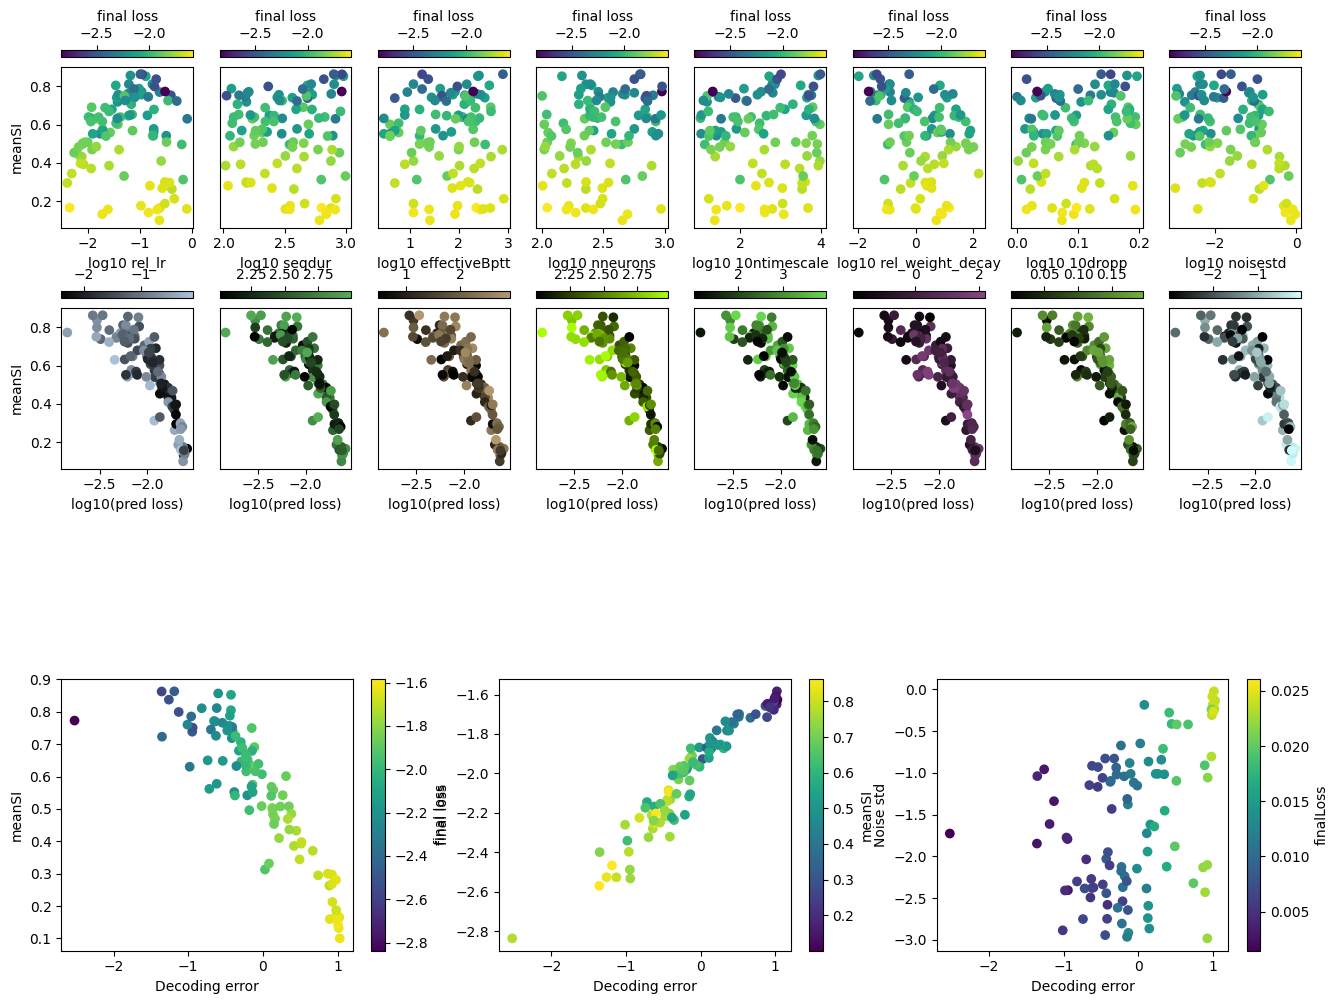

In [60]:

# hparms = ['rel_lr','rel__bias_lr','seqdur','effectiveBptt','nneurons','10ntimescale','10sparsity','rel_weight_decay','10dropp','noisestd' ]
hparms = ['rel_lr','seqdur','effectiveBptt','nneurons','10ntimescale','rel_weight_decay','10dropp','noisestd' ]

numh = len(hparms)

import matplotlib as mplt
colors = list(mplt.colors.XKCD_COLORS) 


#usenets = (analysisFrame['nneurons']>30) & (analysisFrame['rel_weight_decay']<1e-2)
usenets = (analysisFrame['nneurons']>1)
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),(analysisFrame['meanSI'][usenets]),
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),(exampleNet['meanSI']),
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('meanSI')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),analysisFrame['meanSI'][usenets],
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),exampleNet['meanSI'],
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('meanSI')
    else:
        plt.yticks([])

    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['derror'][usenets]),np.log10(analysisFrame['noisestd'][usenets]),
           c=(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('Decoding error')
    plt.ylabel('Noise std')
    plt.colorbar(label='finalLoss')
    
    # plt.subplot(3,3,8)    
    # plt.scatter(np.log10(analysisFrame['10dropp'][usenets]),np.log10(analysisFrame['noisestd'][usenets]),
    #        c=(analysisFrame['meanSI'][usenets]))
    # plt.xlabel('Drop P')
    # plt.ylabel('Noise std')
    # plt.colorbar(label='meanSI')

    plt.subplot(3,3,8)    
    plt.scatter(np.log10(analysisFrame['derror'][usenets]),np.log10(analysisFrame['finalLoss'][usenets]),
           c=(analysisFrame['meanSI'][usenets]))
    plt.xlabel('Decoding error')
    plt.ylabel('final loss')
    plt.colorbar(label='meanSI')
    
    
    plt.subplot(3,3,7)    
    plt.scatter(np.log10(analysisFrame['derror'][usenets]),analysisFrame['meanSI'][usenets],
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('Decoding error')
    plt.ylabel('meanSI')
    plt.colorbar(label='final loss')
    
    
    # plt.subplot(3,3,7)    
    # plt.scatter(np.log10(analysisFrame['nneurons'][usenets]),np.log10(analysisFrame['10sparsity'][usenets]),
    #        c=(analysisFrame['meanSI'][usenets]))
    # plt.xlabel('N Neurons')
    # plt.ylabel('Sparsity')
    # plt.colorbar(label='meanSI')
        

saveFig(plt.gcf(),'MeanSI',savefolder,
        filetype='pdf')
plt.show()

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1435422/2421155420.py:59: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


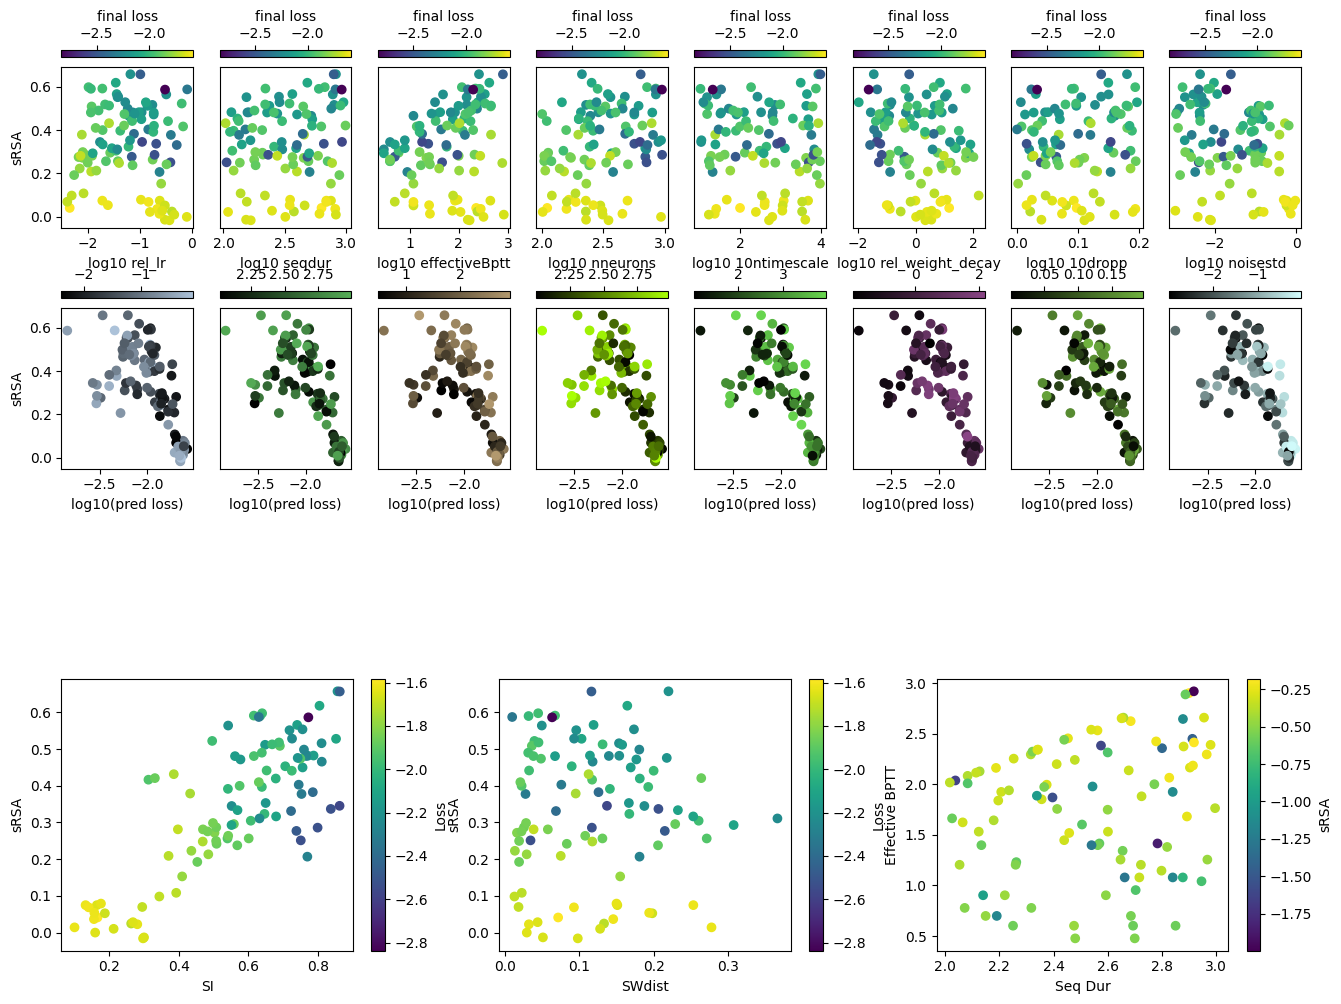

In [15]:
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),analysisFrame['sRSA'][usenets],
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),exampleNet['sRSA'],
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('sRSA')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),analysisFrame['sRSA'][usenets],
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),exampleNet['sRSA'],
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('sRSA')
    else:
        plt.yticks([])
        
    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['seqdur'][usenets]),np.log10(analysisFrame['effectiveBptt'][usenets]),
           c=np.log10(analysisFrame['sRSA'][usenets]))
    plt.xlabel('Seq Dur')
    plt.ylabel('Effective BPTT')
    plt.colorbar(label='sRSA')
    
    
    plt.subplot(3,3,7)    
    plt.scatter((analysisFrame['meanSI'][usenets]),(analysisFrame['sRSA'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SI')
    plt.ylabel('sRSA')
    plt.colorbar(label='Loss')
    
    
    plt.subplot(3,3,8)    
    plt.scatter((analysisFrame['SWdist'][usenets]),(analysisFrame['sRSA'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SWdist')
    plt.ylabel('sRSA')
    plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'sRSA',savefolder,
        filetype='pdf')
plt.show()

/tmp/ipykernel_1435422/4060649433.py:51: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


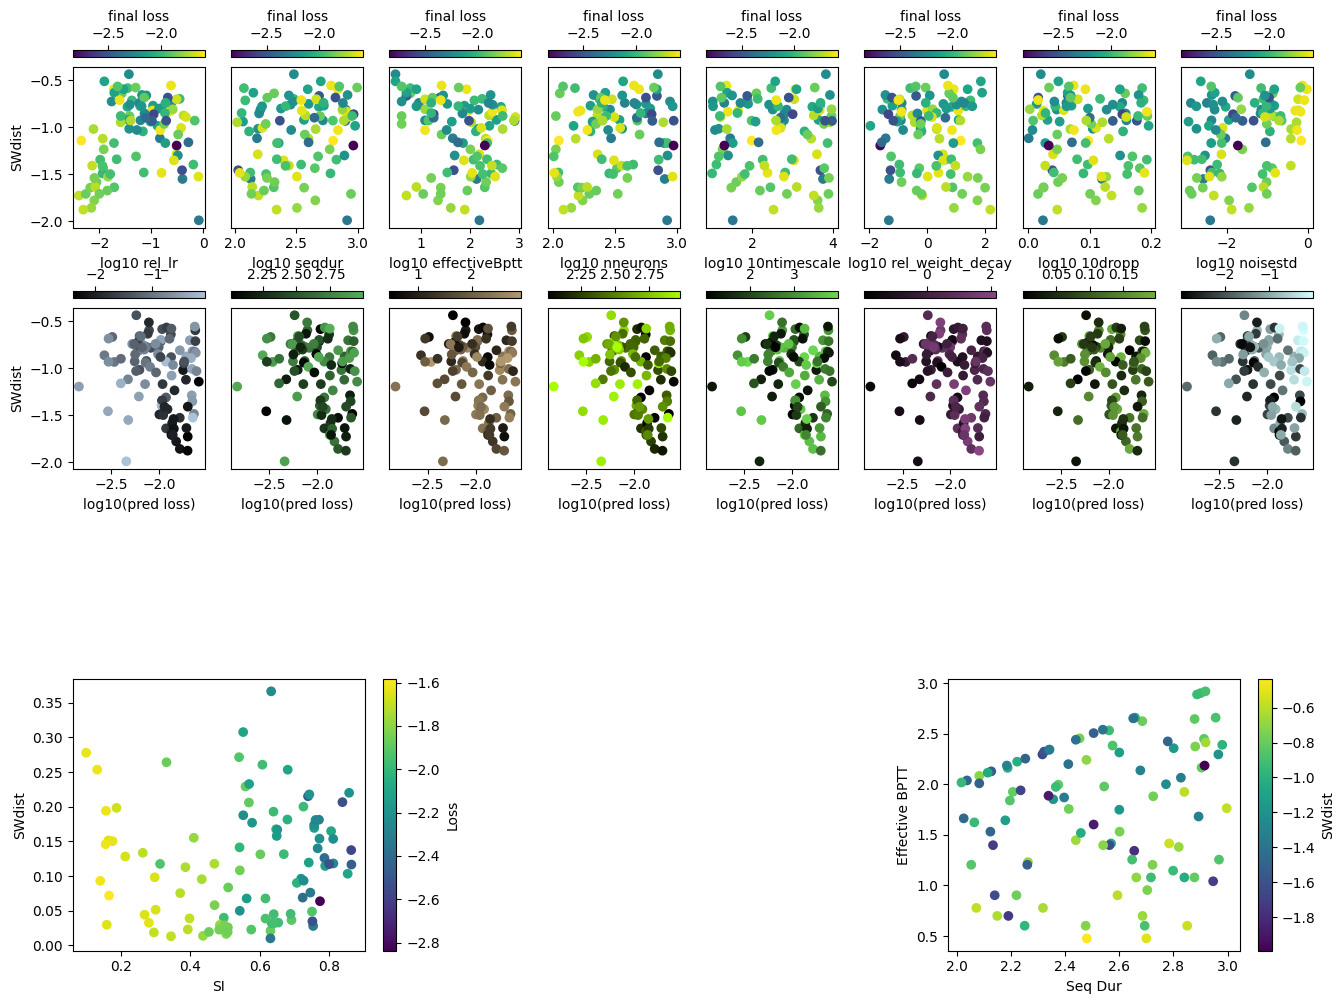

In [16]:
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),np.log10(analysisFrame['SWdist'][usenets]),
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),np.log10(exampleNet['SWdist']),
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('SWdist')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),np.log10(analysisFrame['SWdist'][usenets]),
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),np.log10(exampleNet['SWdist']),
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('SWdist')
    else:
        plt.yticks([])
        
    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['seqdur'][usenets]),np.log10(analysisFrame['effectiveBptt'][usenets]),
           c=np.log10(analysisFrame['SWdist'][usenets]))
    plt.xlabel('Seq Dur')
    plt.ylabel('Effective BPTT')
    plt.colorbar(label='SWdist')
    
    
    plt.subplot(3,3,7)    
    plt.scatter((analysisFrame['meanSI'][usenets]),(analysisFrame['SWdist'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SI')
    plt.ylabel('SWdist')
    plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'SWdist',savefolder,
        filetype='pdf')
plt.show()

In [51]:
aF_seq_5 = analysisFrame

### Sequenced, k=1

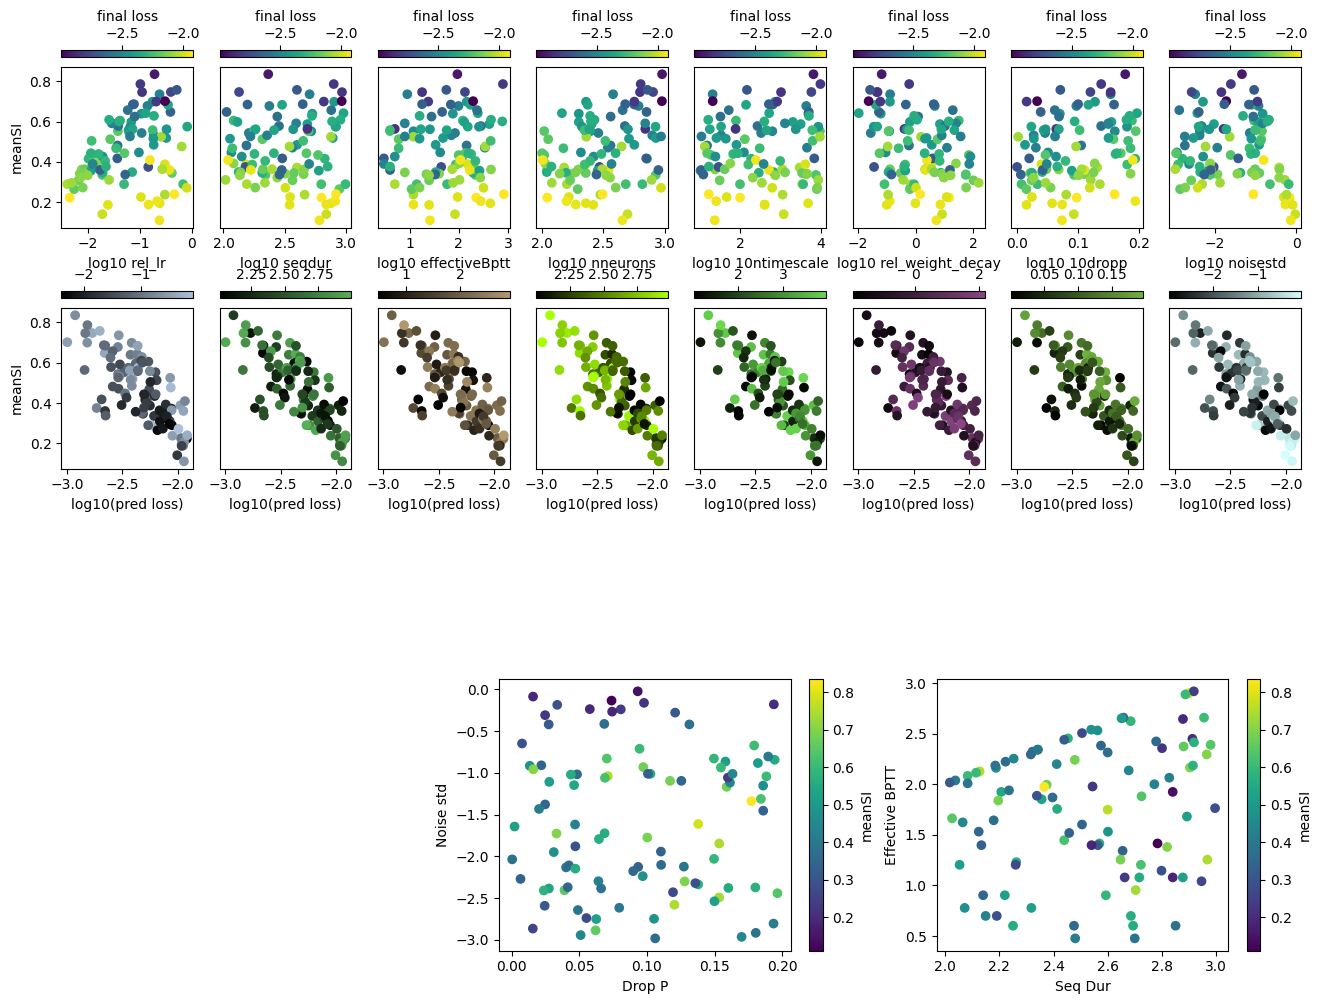

In [49]:
# hparms = ['rel_lr','rel__bias_lr','seqdur','effectiveBptt','nneurons','10ntimescale','10sparsity','rel_weight_decay','10dropp','noisestd' ]
hparms = ['rel_lr','seqdur','effectiveBptt','nneurons','10ntimescale','rel_weight_decay','10dropp','noisestd' ]

numh = len(hparms)

import matplotlib as mplt
colors = list(mplt.colors.XKCD_COLORS) 


#usenets = (analysisFrame['nneurons']>30) & (analysisFrame['rel_weight_decay']<1e-2)
usenets = (analysisFrame['nneurons']>1)
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),(analysisFrame['meanSI'][usenets]),
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),(exampleNet['meanSI']),
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('meanSI')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),analysisFrame['meanSI'][usenets],
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),exampleNet['meanSI'],
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('meanSI')
    else:
        plt.yticks([])
        
    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['seqdur'][usenets]),np.log10(analysisFrame['effectiveBptt'][usenets]),
           c=(analysisFrame['meanSI'][usenets]))
    plt.xlabel('Seq Dur')
    plt.ylabel('Effective BPTT')
    plt.colorbar(label='meanSI')
    
    plt.subplot(3,3,8)    
    plt.scatter(np.log10(analysisFrame['10dropp'][usenets]),np.log10(analysisFrame['noisestd'][usenets]),
           c=(analysisFrame['meanSI'][usenets]))
    plt.xlabel('Drop P')
    plt.ylabel('Noise std')
    plt.colorbar(label='meanSI')
    
    
    # plt.subplot(3,3,7)    
    # plt.scatter(np.log10(analysisFrame['nneurons'][usenets]),np.log10(analysisFrame['10sparsity'][usenets]),
    #        c=(analysisFrame['meanSI'][usenets]))
    # plt.xlabel('N Neurons')
    # plt.ylabel('Sparsity')
    # plt.colorbar(label='meanSI')
        

saveFig(plt.gcf(),'MeanSI',savefolder,
        filetype='pdf')
plt.show()

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1435422/2421155420.py:59: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


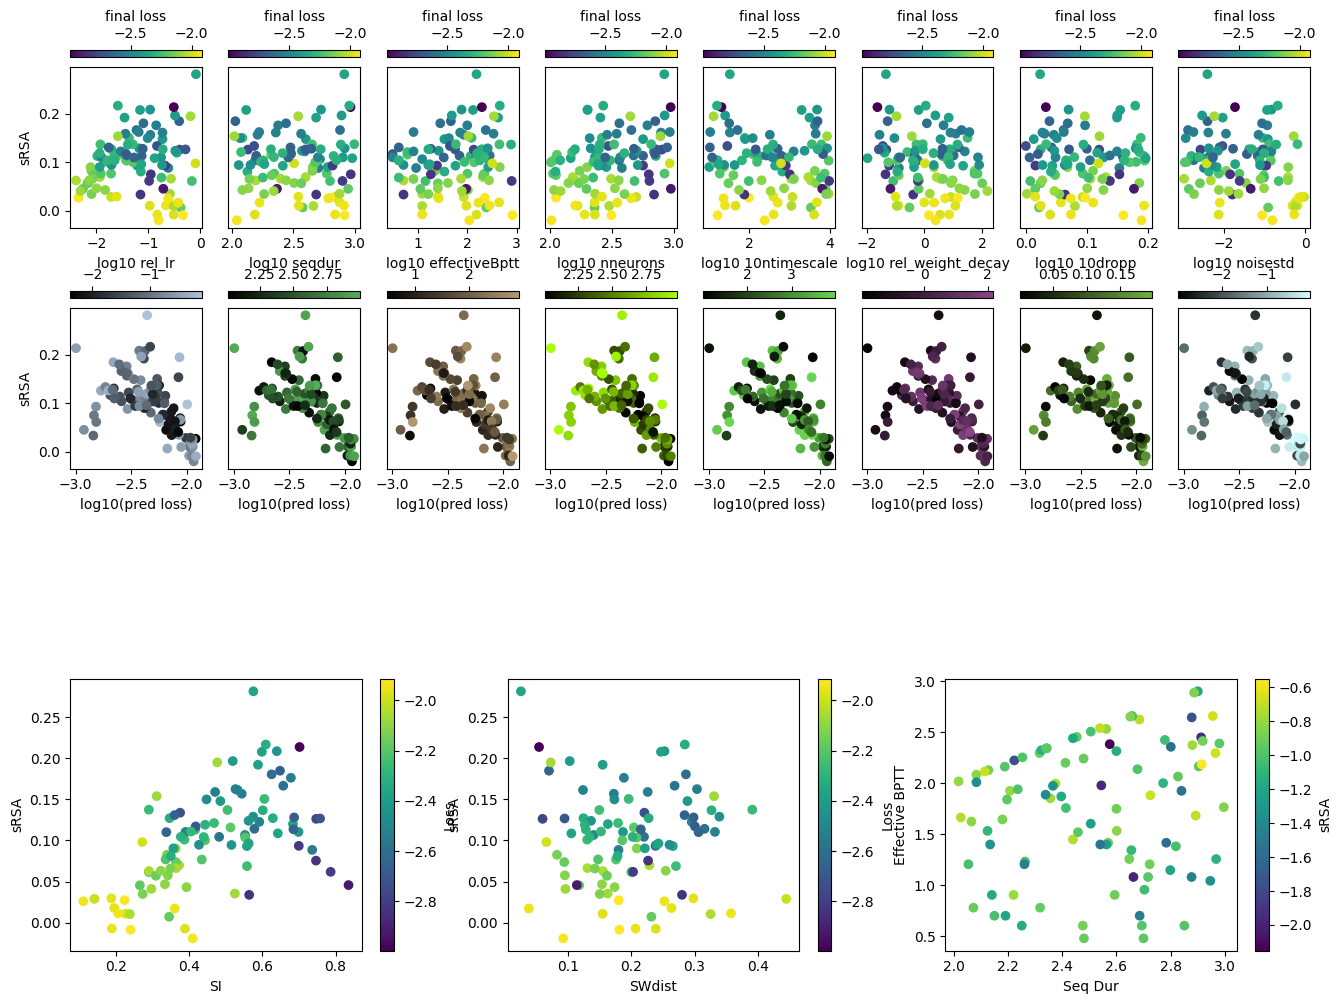

In [50]:
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),analysisFrame['sRSA'][usenets],
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),exampleNet['sRSA'],
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('sRSA')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),analysisFrame['sRSA'][usenets],
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),exampleNet['sRSA'],
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('sRSA')
    else:
        plt.yticks([])
        
    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['seqdur'][usenets]),np.log10(analysisFrame['effectiveBptt'][usenets]),
           c=np.log10(analysisFrame['sRSA'][usenets]))
    plt.xlabel('Seq Dur')
    plt.ylabel('Effective BPTT')
    plt.colorbar(label='sRSA')
    
    
    plt.subplot(3,3,7)    
    plt.scatter((analysisFrame['meanSI'][usenets]),(analysisFrame['sRSA'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SI')
    plt.ylabel('sRSA')
    plt.colorbar(label='Loss')
    
    
    plt.subplot(3,3,8)    
    plt.scatter((analysisFrame['SWdist'][usenets]),(analysisFrame['sRSA'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SWdist')
    plt.ylabel('sRSA')
    plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'sRSA',savefolder,
        filetype='pdf')
plt.show()

/tmp/ipykernel_1435422/4060649433.py:51: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


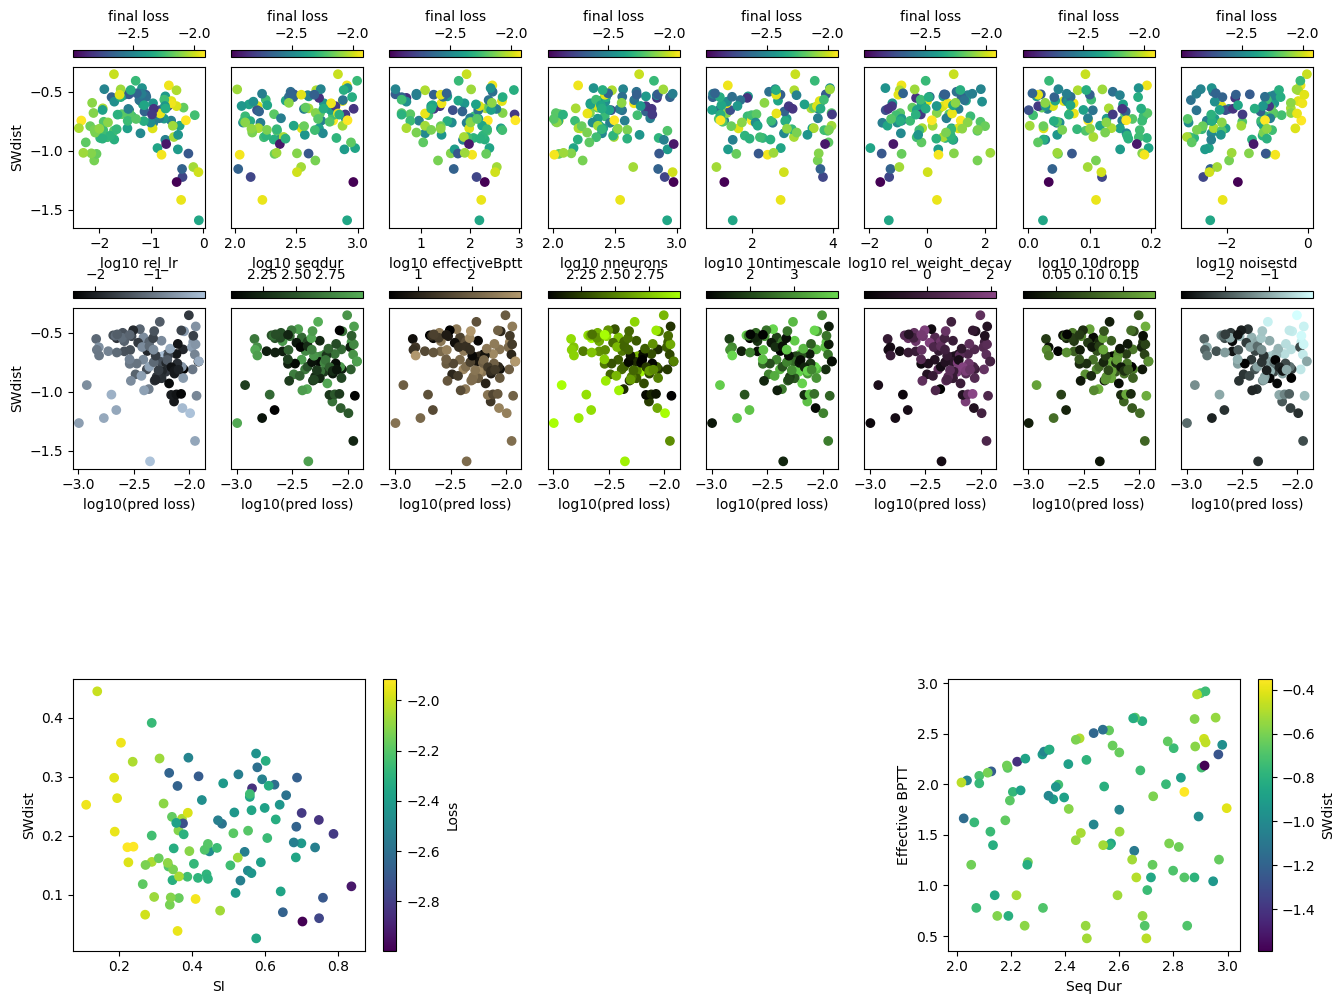

In [51]:
plt.figure(figsize=(16, 12))

for idx,h in enumerate(hparms):
    cmap = mplt.colors.LinearSegmentedColormap.from_list("", ["black",colors[idx]])
    
    plt.subplot(4,numh,idx+1)
    plt.scatter(np.log10(analysisFrame[h][usenets]),np.log10(analysisFrame['SWdist'][usenets]),
               c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.colorbar(label='final loss',location='top')
    # plt.scatter(np.log10(exampleNet[h]),np.log10(exampleNet['SWdist']),
    #             c='k',marker='*')
               #c=np.log10(exampleNet['finalLoss']),marker='*')
    if idx==0:
        plt.ylabel('SWdist')
    else:
        plt.yticks([])
    plt.xlabel('log10 '+h)
    
    
    plt.subplot(4,numh,idx+1+numh)
    plt.scatter(np.log10(analysisFrame['finalLoss'][usenets]),np.log10(analysisFrame['SWdist'][usenets]),
               c=np.log10(analysisFrame[h][usenets]),cmap=cmap)
    plt.colorbar(location='top')
    # plt.scatter(np.log10(exampleNet['finalLoss']),np.log10(exampleNet['SWdist']),
    #             c='k',marker='*')
               ##c=np.log10(exampleNet[h]),marker='*')
    
    plt.xlabel('log10(pred loss)')
    if idx==0:
        plt.ylabel('SWdist')
    else:
        plt.yticks([])
        
    plt.subplot(3,3,9)    
    plt.scatter(np.log10(analysisFrame['seqdur'][usenets]),np.log10(analysisFrame['effectiveBptt'][usenets]),
           c=np.log10(analysisFrame['SWdist'][usenets]))
    plt.xlabel('Seq Dur')
    plt.ylabel('Effective BPTT')
    plt.colorbar(label='SWdist')
    
    
    plt.subplot(3,3,7)    
    plt.scatter((analysisFrame['meanSI'][usenets]),(analysisFrame['SWdist'][usenets]),
           c=np.log10(analysisFrame['finalLoss'][usenets]))
    plt.xlabel('SI')
    plt.ylabel('SWdist')
    plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'SWdist',savefolder,
        filetype='pdf')
plt.show()

In [16]:
aF_seq_1 = analysisFrame

In [18]:
analysisFrame[analysisFrame['sRSA']>0.6][['filename','meanSI','sRSA','nneurons']]

filename    meanSI      sRSA  nneurons
3    thRNN_5win-0-s4000  0.804736  0.618000     254.0
52  thRNN_5win-10-s3000  0.856476  0.657282     212.0
72  thRNN_5win-14-s3000  0.863054  0.656756     634.0

### Sequenced, k=5

In [72]:
entity, project = "peyrache-richards", "Hparams_midsparse_comparison"
runs = api.runs(entity + "/" + project)

In [73]:
for run in runs:
    if run.state == "finished":
        for i, row in run.history().iterrows():
            if row['return_mean']>=0.45:
                a = run.name[6]
                b = run.name[8:10]
                if b[0] == '0':
                    b = b[1]
                name = 'thRNN_5win-'+b+'-s'+a+'000'
                if 'Visual' in run.name:
                    aF_seq_5.loc[aF_seq_5['filename']==name,'half-max_vis']=row['frames']
                elif 'Intrinsic' in run.name:
                    aF_seq_5.loc[aF_seq_5['filename']==name,'half-max_int']=row['frames']
                else:
                    aF_seq_5.loc[aF_seq_5['filename']==name,'half-max_spat']=row['frames']
                break
                

In [74]:
def getVisToSpatRatio(row):
    return row['half-max_spat']/row['half-max_vis']

def getIntToSpatRatio(row):
    return row['half-max_spat']/row['half-max_int']

In [75]:
aF_seq_5['vis_spat_ratio'] = aF_seq_5.apply(getVisToSpatRatio, axis = 1)
aF_seq_5['int_spat_ratio'] = aF_seq_5.apply(getIntToSpatRatio, axis = 1)

In [76]:
import math
def getTrainingSpeedVis(row):
    half = row['half-max_vis']
    if math.isnan(half):
        speed = 0
    else:
        speed = 5e6/half
    
    return speed


def getTrainingSpeedInt(row):
    half = row['half-max_int']
    if math.isnan(half):
        speed = 0
    else:
        speed = 5e6/half
    
    return speed


def getTrainingSpeed(row):
    half = row['half-max_spat']
    if math.isnan(half):
        speed = 0
    else:
        speed = 5e6/half
    
    return speed


In [77]:
aF_seq_5['trainingSpeed_vis'] = aF_seq_5.apply(getTrainingSpeedVis, axis = 1)
aF_seq_5['trainingSpeed_int'] = aF_seq_5.apply(getTrainingSpeedInt, axis = 1)
aF_seq_5['trainingSpeed'] = aF_seq_5.apply(getTrainingSpeed, axis = 1)

In [57]:
aF_seq_5.to_pickle(savefolder+'aF_seq_5.pkl')

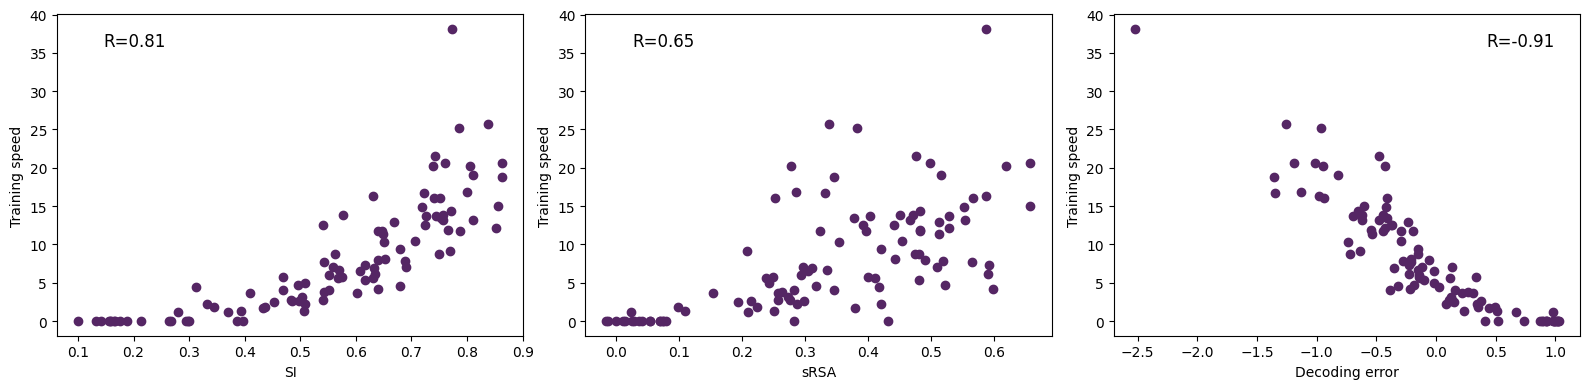

In [13]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['nneurons']>1)


sub1 = plt.subplot(1,3,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['trainingSpeed'][usenets]),
            c=CLRS_MILA['purples'][4]
        # c=np.log10(aF_seq_5['finalLoss'][usenets])
        )
plt.text(0.1, 0.9,
         'R={:.2f}'.format(stats.pearsonr((aF_seq_5['meanSI'][usenets]),
                                          (aF_seq_5['trainingSpeed'][usenets])).statistic),
         fontsize=12,
         transform=sub1.transAxes,)
plt.xlabel('SI')
plt.ylabel('Training speed')
# plt.ylabel('$V_L$')
# plt.colorbar(label='Loss')


sub2 = plt.subplot(1,3,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['trainingSpeed'][usenets]),
            c=CLRS_MILA['purples'][4]
        # c=np.log10(aF_seq_5['finalLoss'][usenets])
        )
plt.text(0.1, 0.9,
         'R={:.2f}'.format(stats.pearsonr((aF_seq_5['sRSA'][usenets]),
                                          (aF_seq_5['trainingSpeed'][usenets])).statistic),
         fontsize=12,
         transform=sub2.transAxes,)

plt.xlabel('sRSA')
plt.ylabel('Training speed')
# plt.ylabel('$V_L$')
# plt.colorbar(label='Loss')


sub3 = plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_5['derror'][usenets]),(aF_seq_5['trainingSpeed'][usenets]),
            c=CLRS_MILA['purples'][4]
        # c=np.log10(aF_seq_5['finalLoss'][usenets])
        )
plt.text(0.8, 0.9,
         'R={:.2f}'.format(stats.pearsonr(np.log10(aF_seq_5['derror'][usenets]),
                                          (aF_seq_5['trainingSpeed'][usenets])).statistic),
         fontsize=12,
         transform=sub3.transAxes,)
plt.xlabel('Decoding error')
plt.ylabel('Training speed')
# plt.ylabel('$t_{0.45}$')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_mono',savefolder_5,
        filetype='pdf')
plt.show()

In [46]:
aF_seq_5[aF_seq_5['trainingSpeed']>35][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
77  thRNN_5win-15-s3000  0.772721  0.586348      38.146973          34.877232   

    trainingSpeed_int  
77          73.982008

In [7]:
net = aF_seq_5['net'][77]
net.pRNN.to(device)

model = aF_seq_5['ACnet_int'][77]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


In [21]:
fig = EFS.error_map(HDs=False, scale='viridis')
# fig = EFS.error_map(scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [22]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                 paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_5+"/77_int_err.png")

In [50]:
aF_seq_5[aF_seq_5['sRSA']>0.6][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
3    thRNN_5win-0-s4000  0.804736  0.618000      20.176911          27.431531   
52  thRNN_5win-10-s3000  0.856476  0.657282      14.977952          24.172339   
72  thRNN_5win-14-s3000  0.863054  0.656756      20.689883          26.537024   

    trainingSpeed_int  
3           42.093211  
52          28.062141  
72          46.950120

In [23]:
net = aF_seq_5['net'][72]
net.pRNN.to(device)

model = aF_seq_5['ACnet_int'][72]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [25]:
fig = EFS.error_map(HDs=False, scale='viridis')

In [26]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                 paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_5+"/72_int_err.png")

In [48]:
aF_seq_5[(aF_seq_5['trainingSpeed']>4) & (aF_seq_5['meanSI']<0.4)][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
15  thRNN_5win-3-s1000  0.312829  0.416438       4.615135          28.388445   

    trainingSpeed_int  
15          11.794233

In [ ]:
aF_seq_5[(aF_seq_5['trainingSpeed']>4) & (aF_seq_5['meanSI']<0.4)][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

In [49]:
aF_seq_5[(aF_seq_5['trainingSpeed']<10) & (aF_seq_5['sRSA']>0.58)][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
9    thRNN_5win-1-s5000  0.639729  0.597553       4.048767          25.699013   
38   thRNN_5win-7-s4000  0.615903  0.591100       7.629395          25.169137   
54  thRNN_5win-10-s5000  0.633872  0.589907       5.704220          17.438616   

    trainingSpeed_int  
9           25.699013  
38          27.431531  
54          17.691350

In [27]:
aF_seq_5[aF_seq_5.index==20][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int', 'half-max_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
20  thRNN_5win-4-s1000  0.164435  0.074539            0.0           2.327365   

    trainingSpeed_int  half-max_int  
20           1.394293     3586048.0

In [61]:
net = aF_seq_5['net'][20]
net.pRNN.to(device)

model = aF_seq_5['ACnet_int'][20]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [29]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [32]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                 paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_5+"/20_int_err.png")

In [58]:
net = aF_seq_5['net'][9]
net.pRNN.to(device)

model = aF_seq_5['ACnet_int'][9]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 20000)

In [59]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [60]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_5+"/09_int_err.png")

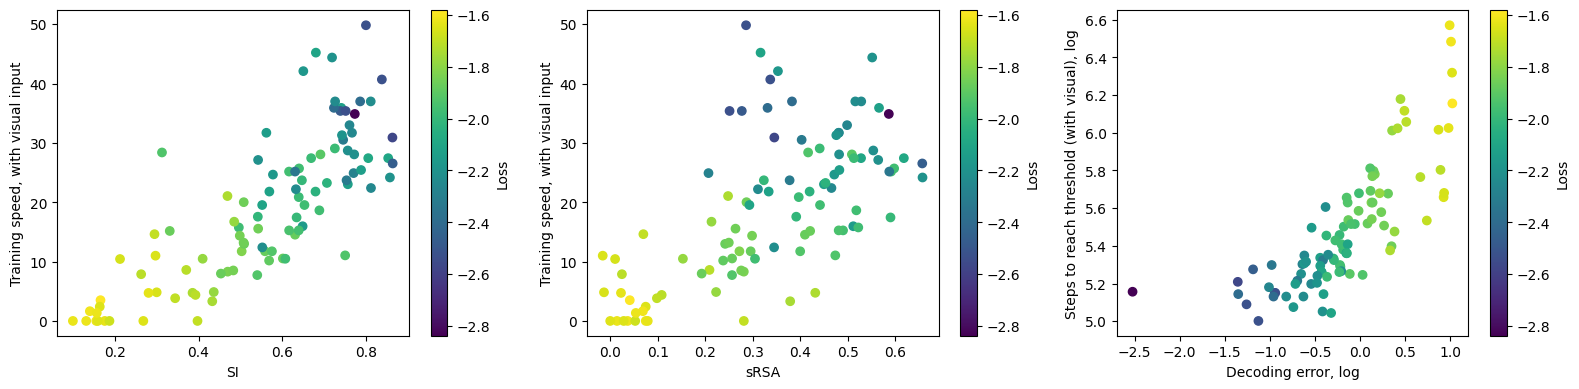

In [100]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['trainingSpeed_vis'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed, with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['trainingSpeed_vis'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed, with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_5['derror'][usenets]),np.log10(aF_seq_5['half-max_vis'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('Decoding error, log')
plt.ylabel('Steps to reach threshold (with visual), log')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_vis',savefolder,
        filetype='pdf')
plt.show()

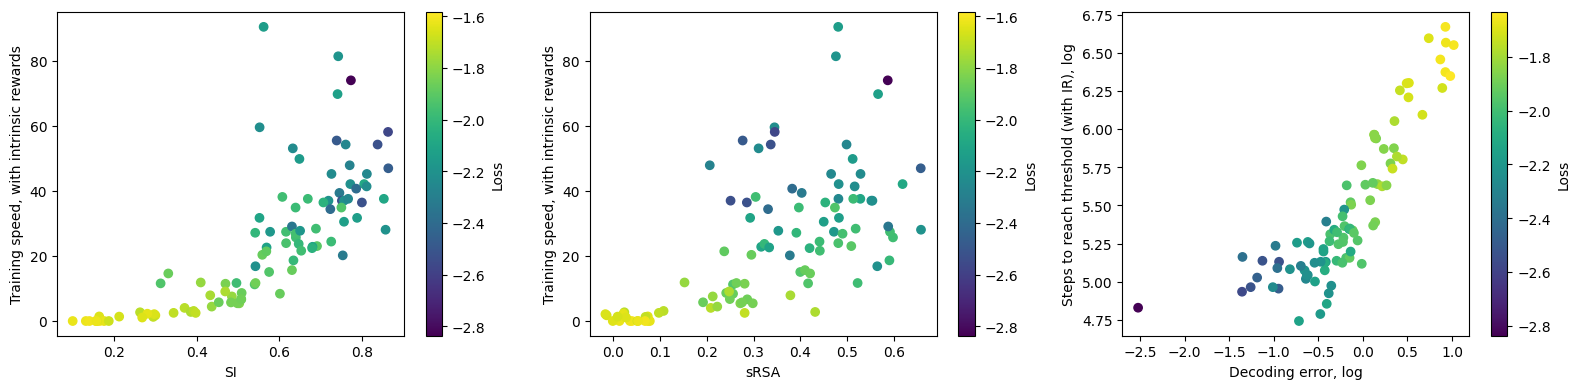

In [101]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_5['derror'][usenets]),np.log10(aF_seq_5['half-max_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('Decoding error, log')
plt.ylabel('Steps to reach threshold (with IR), log')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_int',savefolder,
        filetype='pdf')
plt.show()

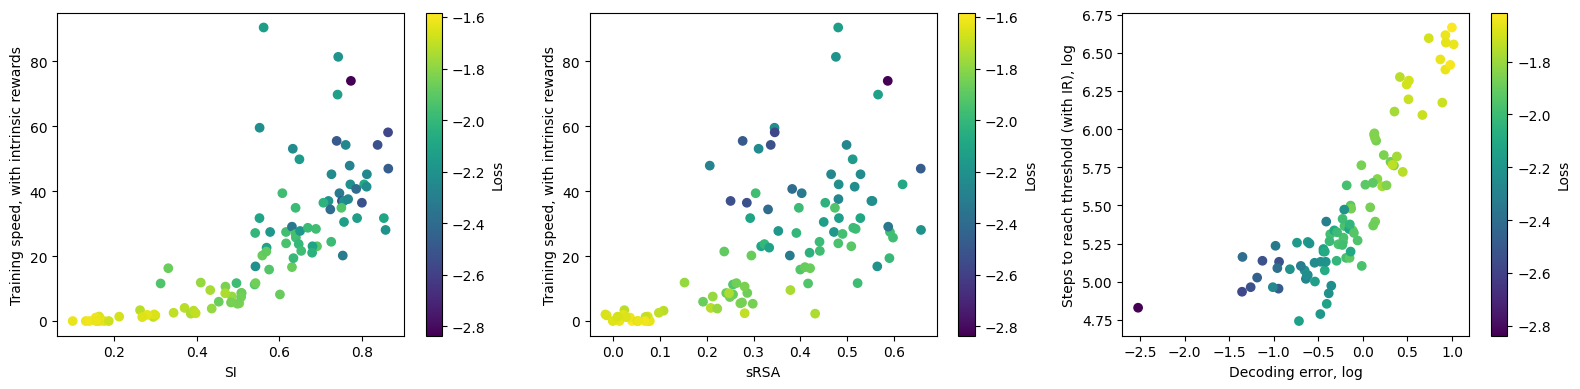

In [69]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_5['derror'][usenets]),np.log10(aF_seq_5['half-max_int'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('Decoding error, log')
plt.ylabel('Steps to reach threshold (with IR), log')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_int',savefolder,
        filetype='pdf')
plt.show()

In [54]:
aF_seq_5[(aF_seq_5['trainingSpeed_int']<10) & (aF_seq_5['sRSA']>0.4)][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
66  thRNN_5win-13-s2000  0.385728  0.431493  0.525679            0.0   

    trainingSpeed_vis  trainingSpeed_int  
66           4.123997           2.786993

In [53]:
dists = aF_seq_5['targetDists'][66]
fig = go.Figure(data=[go.Surface(z=dists)])

fig.update_layout(title='Cosine distance from target', autosize=False,
                  width=500, height=500)

fig.show()

In [55]:
aF_seq_5[(aF_seq_5['trainingSpeed_int']>10) & (aF_seq_5['sRSA']<0.2)][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
51  thRNN_5win-10-s2000  0.409815  0.152854   0.02277       3.869107   

    trainingSpeed_vis  trainingSpeed_int  
51          10.478138          11.851487

In [56]:
aF_seq_5[aF_seq_5['trainingSpeed_int']>80][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
37   thRNN_5win-7-s3000  0.561787  0.480642  0.004127       8.782037   
85  thRNN_5win-17-s1000  0.742072  0.475784  0.087084      21.605365   

    trainingSpeed_vis  trainingSpeed_int  
37          31.706575          90.422454  
85          31.300080          81.380208

In [70]:
aF_seq_5[aF_seq_5['trainingSpeed_int']==0][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
12   thRNN_5win-2-s3000  0.132074  0.074618  0.946185            0.0   
14   thRNN_5win-2-s5000  0.166185  0.040987  0.688395            0.0   
22   thRNN_5win-4-s3000  0.176304  0.078857  0.490558            0.0   
43   thRNN_5win-8-s4000  0.187551  0.052424  0.575122            0.0   
60  thRNN_5win-12-s1000  0.100332  0.014031  0.732597            0.0   
69  thRNN_5win-13-s5000  0.140812  0.068608  0.540422            0.0   
84  thRNN_5win-16-s5000  0.159628 -0.000212  0.003720            0.0   
93  thRNN_5win-18-s4000  0.157290  0.053715  0.818301            0.0   

    trainingSpeed_vis  trainingSpeed_int  
12           0.000000                0.0  
14           3.522953                0.0  
22           0.000000                0.0  
43           0.000000                0.0  
60           0.000000                0.0  
69           1.621120                0.0  
84           0.000000                0.0  
93           1.372348                0.0

In [33]:
net = aF_seq_5['net'][12]
net.pRNN.to(device)

model = aF_seq_5['ACnet_int'][12]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [34]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [47]:
aF_seq_5[(aF_seq_5['trainingSpeed_int']>0) & (aF_seq_5['sRSA']<0)][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
21   thRNN_5win-4-s2000  0.300169 -0.013276            0.0           4.824914   
55  thRNN_5win-11-s1000  0.297376 -0.015958            0.0          10.997325   

    trainingSpeed_int  
21           1.835644  
55           2.115603

In [195]:
aF_seq_5[(aF_seq_5['trainingSpeed_int']>10) & (aF_seq_5['meanSI']<0.4)][['filename','meanSI','sRSA','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  trainingSpeed  trainingSpeed_vis  \
15   thRNN_5win-3-s1000  0.312829  0.416438       4.659172          28.388445   
79  thRNN_5win-15-s5000  0.331367  0.420743       2.248072          15.164014   

    trainingSpeed_int  
15          11.570646  
79          14.619199

In [22]:
aF_seq_5[aF_seq_5['half-max_vis']<1e6]

filename        type  \
0    thRNN_5win-0-s1000  thRNN_5win   
1    thRNN_5win-0-s2000  thRNN_5win   
2    thRNN_5win-0-s3000  thRNN_5win   
3    thRNN_5win-0-s4000  thRNN_5win   
4    thRNN_5win-0-s5000  thRNN_5win   
..                  ...         ...   
93  thRNN_5win-18-s4000  thRNN_5win   
94  thRNN_5win-18-s5000  thRNN_5win   
95  thRNN_5win-19-s1000  thRNN_5win   
96  thRNN_5win-19-s2000  thRNN_5win   
97  thRNN_5win-19-s3000  thRNN_5win   

                                                  net        lr    bptt  \
0   <prnn.utils.predictiveNet.PredictiveNet object...  0.012405     9.0   
1   <prnn.utils.predictiveNet.PredictiveNet object...  0.002624   470.0   
2   <prnn.utils.predictiveNet.PredictiveNet object...  0.006446    84.0   
3   <prnn.utils.predictiveNet.PredictiveNet object...  0.002182   420.0   
4   <prnn.utils.predictiveNet.PredictiveNet object...  0.000947   206.0   
..                                                ...       ...     ...   
93  <prnn.utils.predictiveNet.PredictiveNet object...  0.001395  1571.0   
94  <prnn.utils.predictiveNet.PredictiveNet object...  0.001415   899.0   
95  <prnn.utils.predictiveNet.PredictiveNet object...  0.018870    29.0   
96  <prnn.utils.predictiveNet.PredictiveNet object...  0.000545  1249.0   
97  <prnn.utils.predictiveNet.PredictiveNet object...  0.006043    11.0   

    seqdur    seed     dropp  ntimescale  weight_decay  ...  rel_weight_decay  \
0    431.0  1000.0  0.153335    1.309331      0.001623  ...          0.130803   
1    118.0  2000.0  0.188299    1.888089      0.081830  ...         31.188465   
2    154.0  3000.0  0.046125    2.510951      0.000180  ...          0.027922   
3    415.0  4000.0  0.149595    3.493849      0.015142  ...          6.939710   
4    348.0  5000.0  0.131353    3.465947      0.002508  ...          2.648030   
..     ...     ...       ...         ...           ...  ...               ...   
93   146.0  4000.0  0.120812    3.322532      0.028606  ...         20.502736   
94   107.0  5000.0  0.135994    1.685569      0.004392  ...          3.104502   
95   270.0  1000.0  0.072967    2.663966      0.001028  ...          0.054480   
96   192.0  2000.0  0.134033    3.999700      0.019288  ...         35.403732   
97   533.0  3000.0  0.000580    1.728173      0.012305  ...          2.036145   

      rel_lr  rel__bias_lr   10dropp  10ntimescale  10sparsity   half-max  \
0   0.241498      0.808981  1.423427     20.385949    3.042869   454656.0   
1   0.042388      5.073612  1.542762     77.283861    1.583068   231424.0   
2   0.109397      3.882001  1.112051    324.303096    3.838700   235520.0   
3   0.034774      2.550475  1.411221   3117.808128    2.392648   184320.0   
4   0.011679      0.766859  1.353172   2923.792816    1.353728   892928.0   
..       ...           ...       ...           ...         ...        ...   
93  0.015847      1.451782  1.320724   2101.513834    3.137593  1280000.0   
94  0.014769      0.094770  1.367709     48.480664    3.939085   501760.0   
95  0.291115     12.041508  1.182952    461.281882    1.818695   215040.0   
96  0.007309      0.069639  1.361549   9993.093940    1.273224   462848.0   
97  0.083740      0.307253  1.001337     53.477712    2.802512   206848.0   

    half-max_vis  half-max_spat  vis_spat_ratio  
0       454656.0       696320.0        1.531532  
1       231424.0       303104.0        1.309735  
2       235520.0       505856.0        2.147826  
3       276480.0       184320.0        0.666667  
4       892928.0      3977216.0        4.454128  
..           ...            ...             ...  
93      264192.0      1183744.0        4.480620  
94      501760.0      4233216.0        8.436735  
95      215040.0       212992.0        0.990476  
96      462848.0            NaN             NaN  
97      206848.0       436224.0        2.108911  

[69 rows x 32 columns]

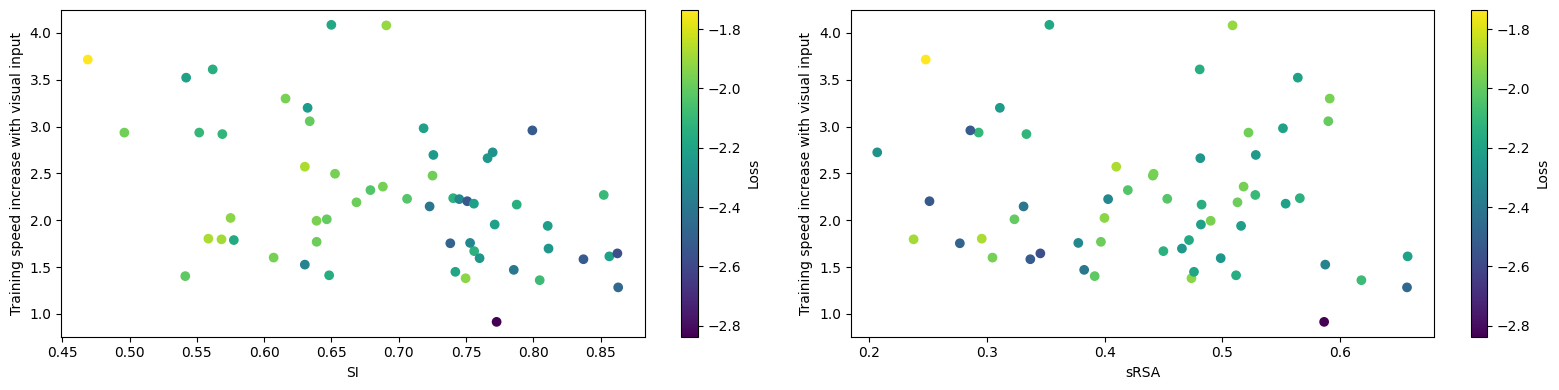

In [20]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['half-max_spat']<1e6)


plt.subplot(1,2,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['vis_spat_ratio'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed increase with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['vis_spat_ratio'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with visual input')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'vis_spat_ratio_topperformant',savefolder,
        filetype='pdf')
plt.show()

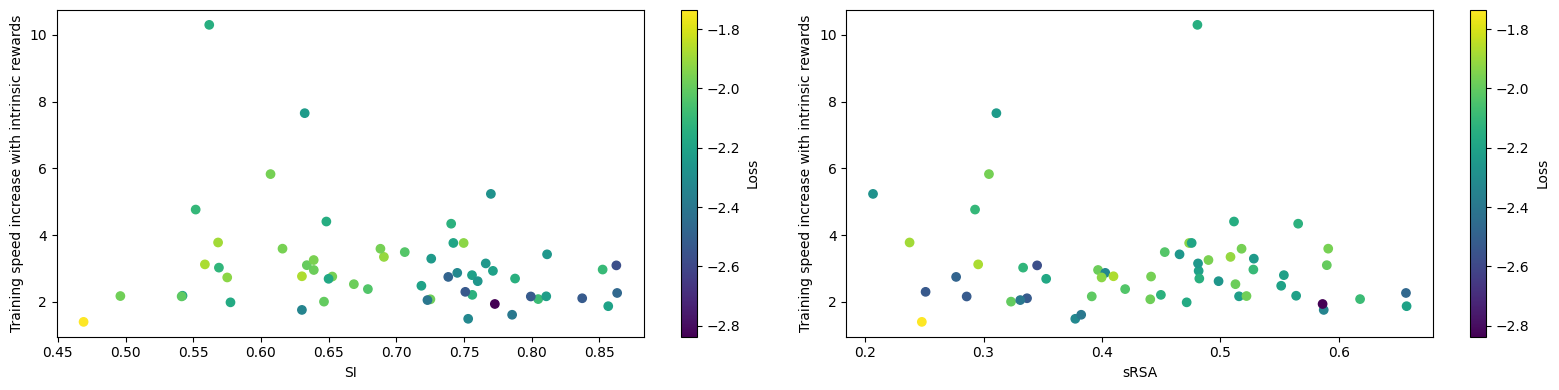

In [21]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_5['half-max_spat']<1e6)


plt.subplot(1,2,1)    
plt.scatter((aF_seq_5['meanSI'][usenets]),(aF_seq_5['int_spat_ratio'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed increase with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_5['sRSA'][usenets]),(aF_seq_5['int_spat_ratio'][usenets]),
        c=np.log10(aF_seq_5['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with intrinsic rewards')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'int_spat_ratio_topperformant',savefolder,
        filetype='pdf')
plt.show()

### Sequenced, k=1

In [5]:
entity, project = "peyrache-richards", "Hparams_midsparse_comparison_k1"
runs = api.runs(entity + "/" + project)

In [20]:
for run in runs:
    if run.state == "finished":
        for i, row in run.history().iterrows():
            if row['return_mean']>=0.45:
                a = run.name[6]
                b = run.name[8:10]
                if b[0] == '0':
                    b = b[1]
                name = 'thRNN_1win-'+b+'-s'+a+'000'
                if 'Visual' in run.name:
                    aF_seq_1.loc[aF_seq_1['filename']==name,'half-max_vis']=row['frames']
                elif 'Intrinsic' in run.name:
                    aF_seq_1.loc[aF_seq_1['filename']==name,'half-max_int']=row['frames']
                else:
                    aF_seq_1.loc[aF_seq_1['filename']==name,'half-max_spat']=row['frames']
                break

In [23]:
aF_seq_1['vis_spat_ratio'] = aF_seq_1.apply(getVisToSpatRatio, axis = 1)

aF_seq_1['int_spat_ratio'] = aF_seq_1.apply(getIntToSpatRatio, axis = 1)

In [24]:
aF_seq_1['trainingSpeed'] = aF_seq_1.apply(getTrainingSpeed, axis = 1)

aF_seq_1['trainingSpeed_vis'] = aF_seq_1.apply(getTrainingSpeedVis, axis = 1)

aF_seq_1['trainingSpeed_int'] = aF_seq_1.apply(getTrainingSpeedInt, axis = 1)

In [25]:
# aF_seq_1.to_csv(savefolder+'aF_seq_1.csv')
aF_seq_1.to_pickle(savefolder+'aF_seq_1.pkl')

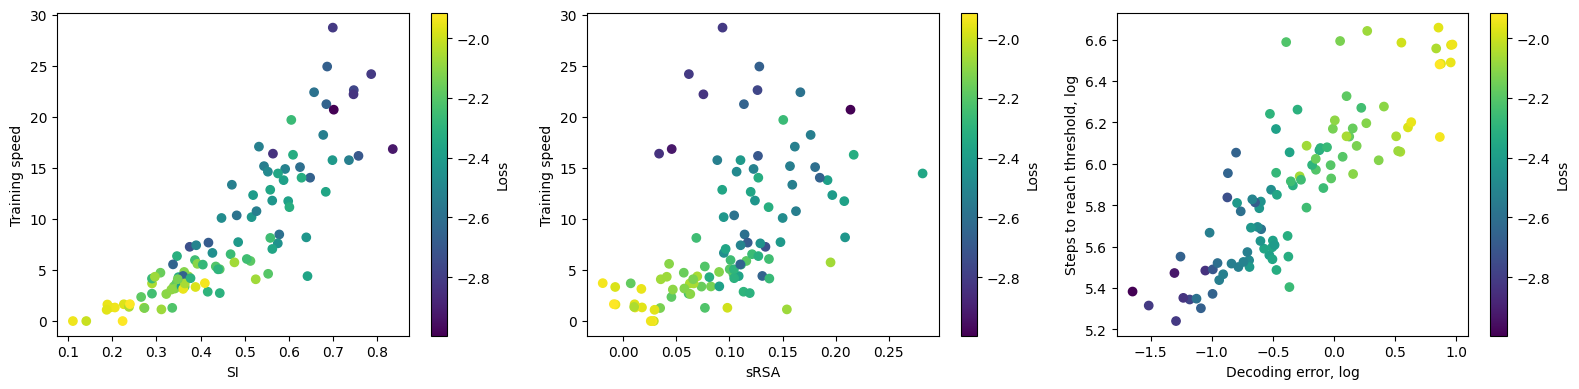

In [75]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_1['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_1['meanSI'][usenets]),(aF_seq_1['trainingSpeed'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_1['sRSA'][usenets]),(aF_seq_1['trainingSpeed'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_1['derror'][usenets]),np.log10(aF_seq_1['half-max_spat'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('Decoding error, log')
plt.ylabel('Steps to reach threshold, log')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance',savefolder,
        filetype='pdf')
plt.show()

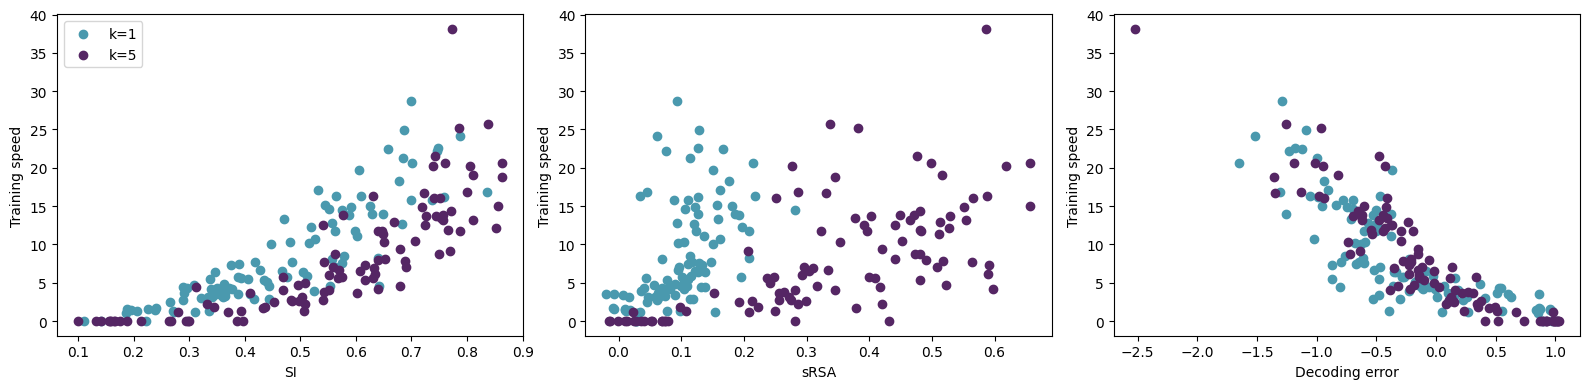

In [20]:
plt.figure(figsize=(16, 4))


plt.subplot(1,3,1)    
plt.scatter((aF_seq_1['meanSI']),(aF_seq_1['trainingSpeed']),
        c=CLRS_MILA['blues'][3])    
plt.scatter((aF_seq_5['meanSI']),(aF_seq_5['trainingSpeed']),
        c=CLRS_MILA['purples'][4])
plt.xlabel('SI')
plt.ylabel('Training speed')
plt.legend(['k=1','k=5'],loc='upper left')
# plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_1['sRSA']),(aF_seq_1['trainingSpeed']),
        c=CLRS_MILA['blues'][3])    
plt.scatter((aF_seq_5['sRSA']),(aF_seq_5['trainingSpeed']),
        c=CLRS_MILA['purples'][4])
plt.xlabel('sRSA')
plt.ylabel('Training speed')
# plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_1['derror']),(aF_seq_1['trainingSpeed']),
        c=CLRS_MILA['blues'][3])    
plt.scatter(np.log10(aF_seq_5['derror']),(aF_seq_5['trainingSpeed']),
        c=CLRS_MILA['purples'][4])
plt.xlabel('Decoding error')
plt.ylabel('Training speed')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'comparison',savefolder_1,
        filetype='pdf')
plt.show()

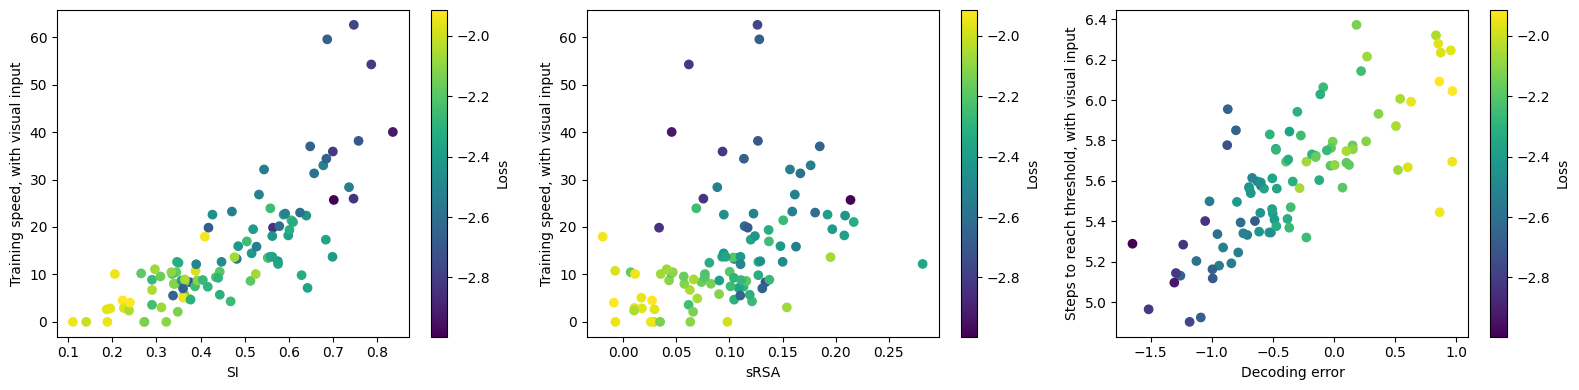

In [77]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_1['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_1['meanSI'][usenets]),(aF_seq_1['trainingSpeed_vis'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed, with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_1['sRSA'][usenets]),(aF_seq_1['trainingSpeed_vis'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed, with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_1['derror'][usenets]),np.log10(aF_seq_1['half-max_vis'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('Decoding error')
plt.ylabel('Steps to reach threshold, with visual input')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_vis',savefolder,
        filetype='pdf')
plt.show()

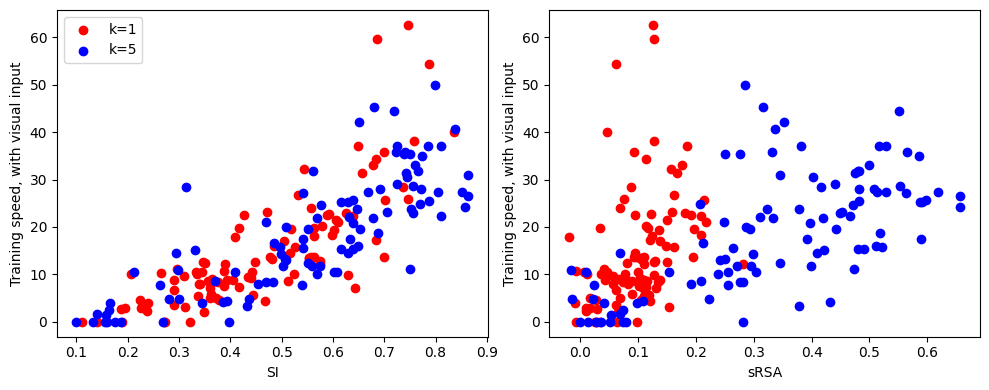

In [9]:
plt.figure(figsize=(10, 4))


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI']),(aF_seq_1['trainingSpeed_vis']),
        c='red')    
plt.scatter((aF_seq_5['meanSI']),(aF_seq_5['trainingSpeed_vis']),
        c='blue')
plt.xlabel('SI')
plt.ylabel('Training speed, with visual input')
plt.legend(['k=1','k=5'],loc='upper left')
# plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA']),(aF_seq_1['trainingSpeed_vis']),
        c='red')    
plt.scatter((aF_seq_5['sRSA']),(aF_seq_5['trainingSpeed_vis']),
        c='blue')
plt.xlabel('sRSA')
plt.ylabel('Training speed, with visual input')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'comparison_vis',savefolder,
        filetype='pdf')
plt.show()

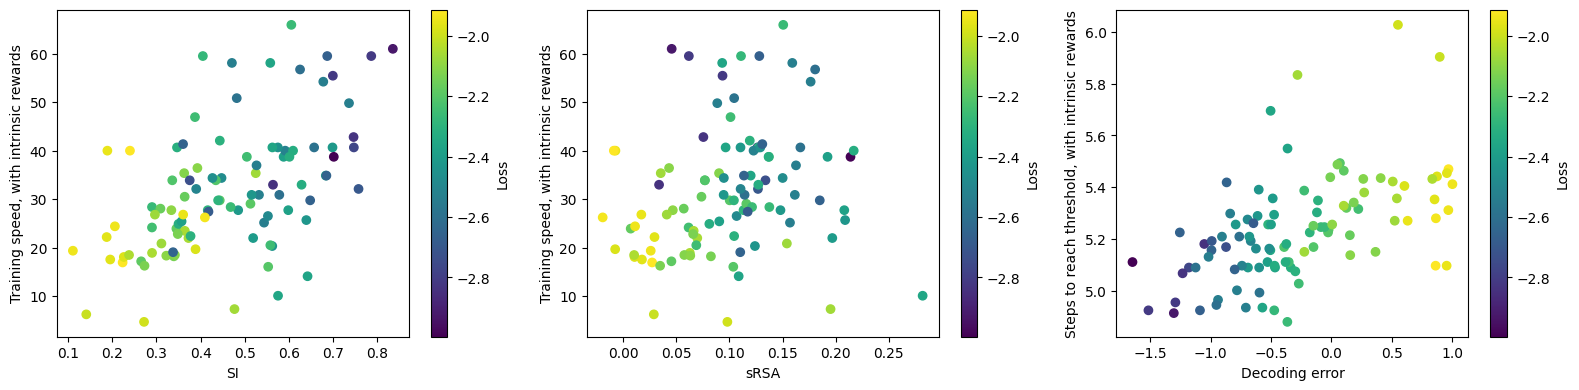

In [78]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_1['nneurons']>1)


plt.subplot(1,3,1)    
plt.scatter((aF_seq_1['meanSI'][usenets]),(aF_seq_1['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,2)    
plt.scatter((aF_seq_1['sRSA'][usenets]),(aF_seq_1['trainingSpeed_int'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed, with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,3,3)    
plt.scatter(np.log10(aF_seq_1['derror'][usenets]),np.log10(aF_seq_1['half-max_int'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('Decoding error')
plt.ylabel('Steps to reach threshold, with intrinsic rewards')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'performance_int',savefolder,
        filetype='pdf')
plt.show()

In [72]:
aF_seq_1[(aF_seq_1['trainingSpeed_int']>60)][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
1    thRNN_1win-0-s2000  0.605453  0.150653  0.090773      19.688760   
83  thRNN_1win-16-s4000  0.835345  0.045635  0.045778      16.837284   

    trainingSpeed_vis  trainingSpeed_int  
1           21.415844          65.983953  
83          40.023053          61.035156

In [35]:
net = aF_seq_1['net'][83]
net.pRNN.to(device)

model = aF_seq_1['ACnet_int'][83]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)


In [36]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [37]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                 paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_1+"/83_int_err.png")

In [22]:
from RLutils.analysis import OnPolicyAnalysis

OPA = OnPolicyAnalysis(timesteps=10000, env=net.env_shell, acmodel=model, predictiveNet=net, device=device,
                       discount=0.99, gae_lambda=0.95, preprocess_obss = get_obss_preprocessor(net.env_shell.observation_space)[1],
                       intrinsic=True, k_int=1)

Store parameters
Control parameters
Configure acmodel
Reset done
Masks done
Values done
Advantages done
Initialize log values
All done


/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/scipy/spatial/distance.py:647: RuntimeWarning:

invalid value encountered in true_divide



In [25]:
fig = OPA.plot_advantages()

In [10]:
fig = EFS.values_map()

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:132: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:80: RuntimeWarning:

Mean of empty slice



In [11]:
fig.write_image(savefolder+"/83_int_val.svg")

In [70]:
aF_seq_1[(aF_seq_1['sRSA']>0.25)][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
58  thRNN_1win-11-s4000  0.575297  0.281865  0.003905      14.446191   

    trainingSpeed_vis  trainingSpeed_int  
58          12.207031          10.088456

In [38]:
net = aF_seq_1['net'][58]
net.pRNN.to(device)

model = aF_seq_1['ACnet_int'][58]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [39]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [40]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_1+"/58_int_err.png")

In [71]:
dists = aF_seq_1['targetDists'][58]
fig = go.Figure(data=[go.Surface(z=dists)])

fig.update_layout(title='Cosine distance from target', autosize=False,
                  width=500, height=500)

fig.show()

In [65]:
aF_seq_1[(aF_seq_1['trainingSpeed_int']>10) & (aF_seq_1['meanSI']<0.2)][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
20   thRNN_1win-4-s1000  0.195238  0.017629  0.579112       1.333373   
60  thRNN_1win-12-s1000  0.110685  0.025908  0.732597       0.000000   
69  thRNN_1win-13-s5000  0.188785 -0.007335  0.540422       1.620044   
93  thRNN_1win-18-s4000  0.187172  0.029445  0.818301       1.099733   

    trainingSpeed_vis  trainingSpeed_int  
20           2.838844          17.564074  
60           0.000000          19.376240  
69           0.000000          40.023053  
93           2.630826          22.194602

In [41]:
net = aF_seq_1['net'][60]
net.pRNN.to(device)

model = aF_seq_1['ACnet_int'][60]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [42]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [44]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_1+"/60_int_err.png")

In [17]:
fig = EFS.values_map()

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:132: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:80: RuntimeWarning:

Mean of empty slice



In [45]:
net = aF_seq_1['net'][20]
net.pRNN.to(device)

model = aF_seq_1['ACnet_int'][20]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 10000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [46]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [47]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)')
fig.write_image(savefolder_1+"/20_int_err.png")

In [28]:
fig = EFS.values_map()

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:132: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:80: RuntimeWarning:

Mean of empty slice



In [54]:
aF_seq_1[(aF_seq_1['filename']=='thRNN_1win-12-s1000')][['filename','meanSI','sRSA','noisestd','trainingSpeed','trainingSpeed_vis','trainingSpeed_int']]

filename    meanSI      sRSA  noisestd  trainingSpeed  \
60  thRNN_1win-12-s1000  0.110685  0.025908  0.732597            0.0   

    trainingSpeed_vis  trainingSpeed_int  
60                0.0           19.37624

In [55]:
net = aF_seq_1['net'][60]
net.pRNN.to(device)

model = aF_seq_1['ACnet_int'][60]
model.to(device)

action_probability = np.array([0.15,0.15,0.6,0.1])
agent = RandomActionAgent(net.env_shell.action_space, action_probability)

EFS = EnvironmentFeaturesAnalysis(net.env_shell, agent, model, net, 20000)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning:

WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.



In [56]:
fig = EFS.error_map(HDs=False, scale='viridis')

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:244: RuntimeWarning:

invalid value encountered in true_divide

/home/mila/a/aleksei.efremov/pRNN-RL/RLutils/analysis.py:52: RuntimeWarning:

Mean of empty slice



In [57]:
fig.update_layout(plot_bgcolor='rgba(0, 0, 0, 0)',
                  paper_bgcolor='rgba(0, 0, 0, 0)')

fig.write_image(savefolder_1+"/60_int_err.png")

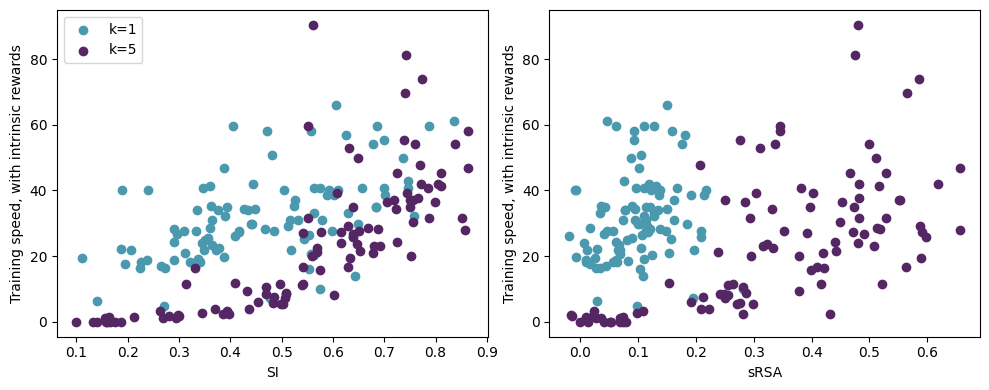

In [5]:
plt.figure(figsize=(10, 4))


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI']),(aF_seq_1['trainingSpeed_int']),
        c=CLRS_MILA['blues'][3])    
plt.scatter((aF_seq_5['meanSI']),(aF_seq_5['trainingSpeed_int']),
        c=CLRS_MILA['purples'][4])
plt.xlabel('SI')
plt.ylabel('Training speed, with intrinsic rewards')
plt.legend(['k=1','k=5'],loc='upper left')
# plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA']),(aF_seq_1['trainingSpeed_int']),
        c=CLRS_MILA['blues'][3])    
plt.scatter((aF_seq_5['sRSA']),(aF_seq_5['trainingSpeed_int']),
        c=CLRS_MILA['purples'][4])
plt.xlabel('sRSA')
plt.ylabel('Training speed, with intrinsic rewards')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'comparison_int',savefolder_1,
        filetype='pdf')
plt.show()

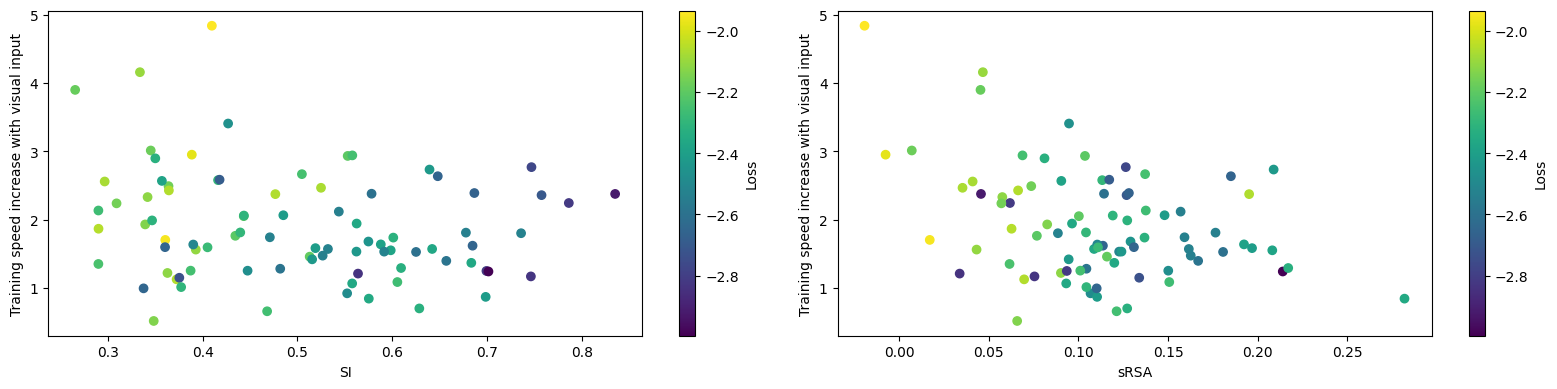

In [41]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_1['half-max_spat']<2e6)


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI'][usenets]),(aF_seq_1['vis_spat_ratio'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed increase with visual input')
plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA'][usenets]),(aF_seq_1['vis_spat_ratio'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with visual input')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'vis_spat_ratio_topperformant',savefolder,
        filetype='pdf')
plt.show()

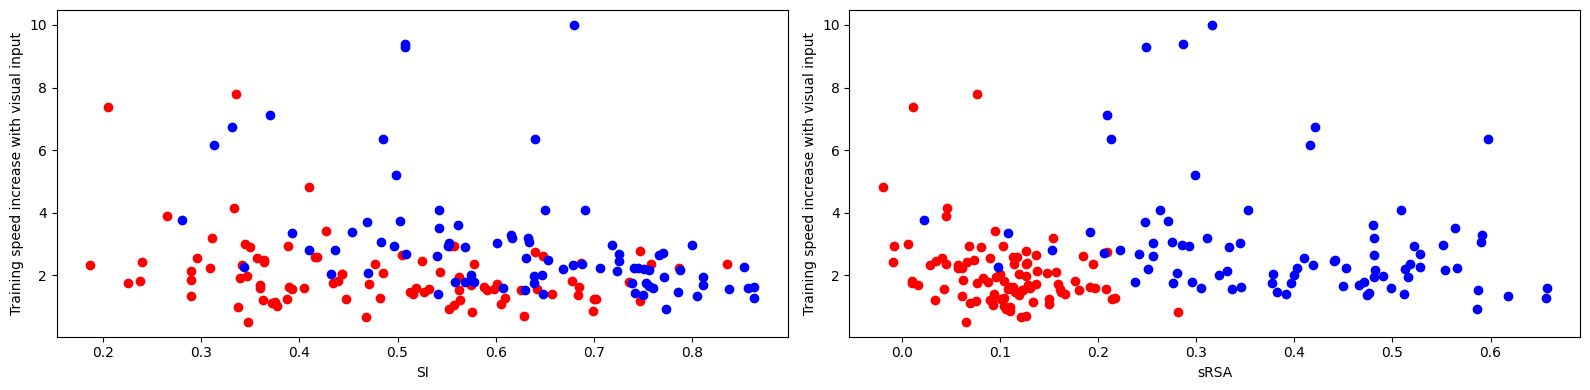

In [42]:
plt.figure(figsize=(16, 4))


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI']),(aF_seq_1['vis_spat_ratio']),
        c='red')    
plt.scatter((aF_seq_5['meanSI']),(aF_seq_5['vis_spat_ratio']),
        c='blue')
plt.xlabel('SI')
plt.ylabel('Training speed increase with visual input')
# plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA']),(aF_seq_1['vis_spat_ratio']),
        c='red')    
plt.scatter((aF_seq_5['sRSA']),(aF_seq_5['vis_spat_ratio']),
        c='blue')
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with visual input')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'comparison',savefolder,
        filetype='pdf')
plt.show()

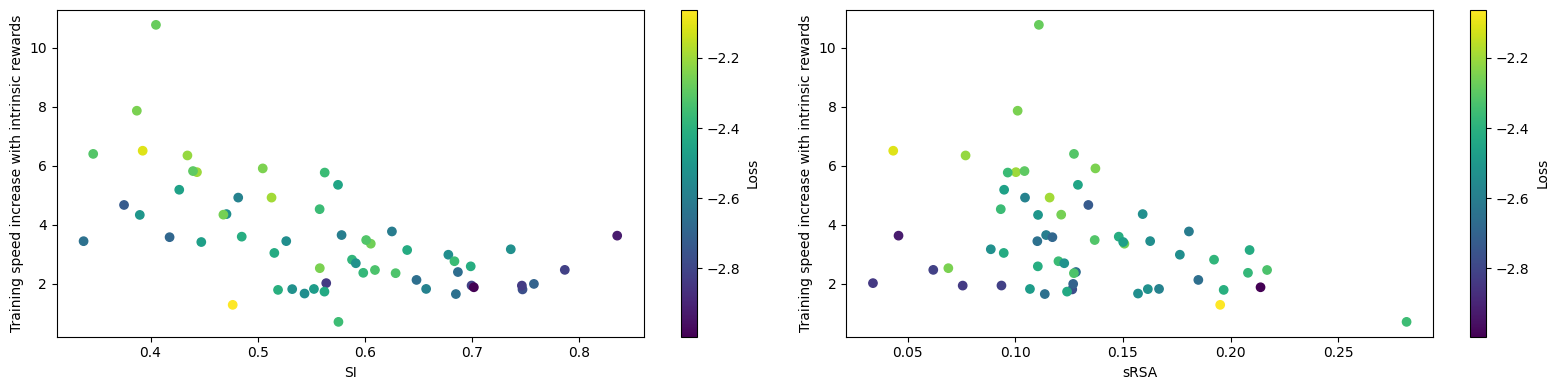

In [43]:
plt.figure(figsize=(16, 4))

usenets = (aF_seq_1['half-max_spat']<1e6)


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI'][usenets]),(aF_seq_1['int_spat_ratio'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('SI')
plt.ylabel('Training speed increase with intrinsic rewards')
plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA'][usenets]),(aF_seq_1['int_spat_ratio'][usenets]),
        c=np.log10(aF_seq_1['finalLoss'][usenets]))
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with intrinsic rewards')
plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'int_spat_ratio_topperformant',savefolder,
        filetype='pdf')
plt.show()

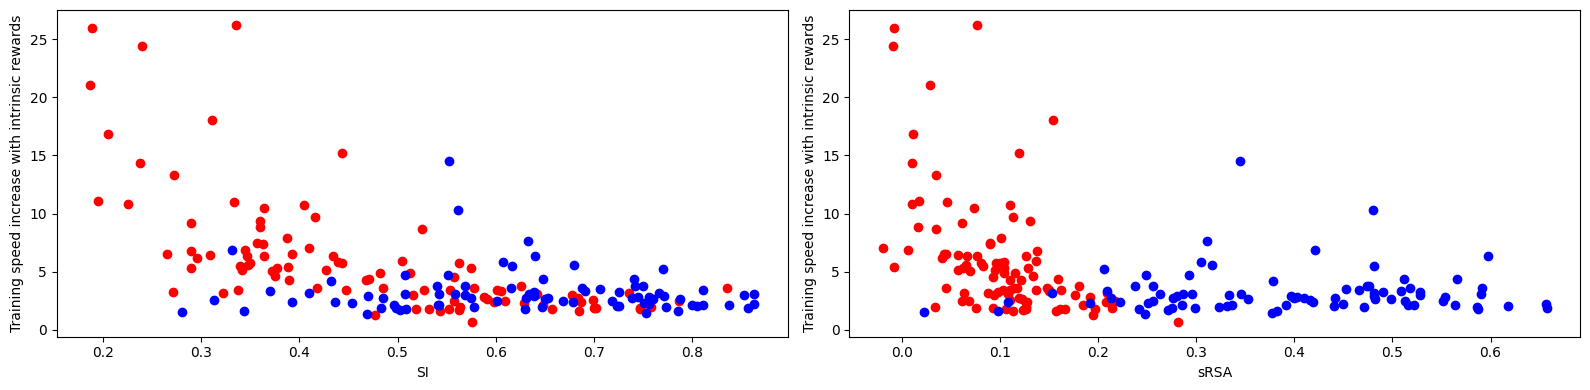

In [44]:
plt.figure(figsize=(16, 4))


plt.subplot(1,2,1)    
plt.scatter((aF_seq_1['meanSI']),(aF_seq_1['int_spat_ratio']),
        c='red')    
plt.scatter((aF_seq_5['meanSI']),(aF_seq_5['int_spat_ratio']),
        c='blue')
plt.xlabel('SI')
plt.ylabel('Training speed increase with intrinsic rewards')
# plt.colorbar(label='Loss')


plt.subplot(1,2,2)    
plt.scatter((aF_seq_1['sRSA']),(aF_seq_1['int_spat_ratio']),
        c='red')    
plt.scatter((aF_seq_5['sRSA']),(aF_seq_5['int_spat_ratio']),
        c='blue')
plt.xlabel('sRSA')
plt.ylabel('Training speed increase with intrinsic rewards')
# plt.colorbar(label='Loss')
    
    

plt.tight_layout()
saveFig(plt.gcf(),'comparison',savefolder,
        filetype='pdf')
plt.show()